# Imports and preparation

In [6]:
import os

In [7]:
import numpy as np

In [8]:
import pandas as pd

In [9]:
from collections import defaultdict

In [10]:
from tqdm import tqdm

In [11]:
import time, gc

In [12]:
import importlib

In [13]:
from itertools import product


In [9]:
from util import util_elastic

OpenAI tiktoken module is not available for Python < 3.8,Linux ARM64 and AARCH64. Falling back to GPT2TokenizerFast.


In [12]:
from util import util_pipeline_v2

In [13]:
from util import util_experiment

In [14]:
# Para ter repetibilidade nos resultados
random_state = 1

# Tratar valores infinitos (+ e -) como np.NaN
pd.options.mode.use_inf_as_na = True

# IMPORTANTE para tornar figuras interativas
# %matplotlib notebook

# Tamanho padrão das figuras
figsize=(10,6)

pd.set_option('display.max_row', 1000)

pd.set_option('display.max_columns', 50)

pd.set_option('display.column_space', 40)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 200)


In [13]:
PATH_QUERY = '../data/juris_tcu_index/query.csv'
PATH_QREL =  '../data/juris_tcu_index/qrel.csv'

# Data load

## Query data load

In [14]:
df_query = pd.read_csv(PATH_QUERY)

In [15]:
df_query.shape

(16045, 11)

In [16]:
df_query[df_query['ID']==2845]

,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME
5618,2845,"Em regra, o pregão é a modalidade de licitação adequada para a concessão remunerada de uso de be...",NaN,NaN,Licitação,932,REPRESENTAÇÃO,Acórdão 478/2016 - Plenário,2016-03-02,RELATOR,MARCOS BEMQUERER


In [17]:
df_query.head()

,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME
0,13568,"É ilegal a contagem de tempo ficto de serviço prestado sob a égide da Lei 3.313/1957, proporcion...",Lei Complementar 51/1985 || Lei Ordinária 3313/1957,NaN,Pessoal,1131,APOSENTADORIA,Acórdão 168/2014 - Segunda Câmara,2014-01-28,RELATOR,JOSÉ JORGE
1,11614,"SÚMULA TCU 283: Para fim de habilitação, a Administração Pública não deve exigir dos licitantes ...",NaN,SUMULA,Licitação,932,ADMINISTRATIVO,Acórdão 1613/2013 - Plenário,2013-06-26,RELATOR,JOSÉ JORGE
2,21087,"A contratação de serviços por preços superiores às referências legais (Sinapi e Sicro) deve ser,...",NaN,NaN,Licitação,932,PRESTAÇÃO DE CONTAS,Acórdão 3936/2013 - Segunda Câmara,2013-07-09,RELATOR,ANA ARRAES
3,35016,"Não se aplica, excepcionalmente, multa aos gestores por grave infração à norma legal se a irregu...",NaN,NaN,Responsabilidade,775,REPRESENTAÇÃO,Acórdão 3231/2011 - Plenário,2011-12-07,RELATOR,AROLDO CEDRAZ
4,29370,"Em contratatações de TI, não cabe aceitar propostas de preço com incidência de encargos majorado...",NaN,NaN,Licitação,932,REPRESENTAÇÃO,Acórdão 3231/2011 - Plenário,2011-12-07,RELATOR,AROLDO CEDRAZ


## Qrel data load

In [18]:
df_qrel = pd.read_csv(PATH_QREL)

In [19]:
df_qrel.shape

(94809, 3)

In [20]:
df_qrel.head()

,ID_QUERY,ID_DOCTO,TYPE
0,158,15147,INDEXACAO_EXTRA
1,37,15147,INDEXACAO_EXTRA
2,178,15147,INDEXACAO_EXTRA
3,14564,15147,INDEXACAO_EXTRA
4,9219,15147,INDEXACAO_EXTRA


In [21]:
df_qrel.shape[0]

94809

In [22]:
df_search_data = df_query.merge(df_qrel, how='left', left_on='ID', right_on='ID_QUERY').drop('ID_QUERY', axis=1)

In [23]:
df_search_data.shape[0]


94809

In [24]:
# Agrupar os dados pelo ID e criar a coluna 'RELEVANCE_LIST' com a lista de tuplas
# df_new = df_search_data.groupby('ID').apply(lambda x: list(zip(x['ID_DOCTO'], x['TYPE']))).reset_index(name='RELEVANCE_LIST')
# df_new['RELEVANCE_LIST'] = df_new['RELEVANCE_LIST'].apply(lambda x: sorted(x, key=lambda tup: ('AREA', 'TEMA', 'SUBTEMA', 'INDEXACAO_EXTRA').index(tup[1])))
df_new = df_search_data.groupby('ID').apply(lambda x: dict(zip(x['ID_DOCTO'], x['TYPE']))).reset_index(name='RELEVANCE_DICT')


In [25]:
df_new.head()

,ID,RELEVANCE_DICT
0,5,"{1298: 'INDEXACAO_EXTRA', 15340: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106..."
1,6,"{207: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106: 'SUBTEMA', 1113: 'TEMA'}"
2,7,"{108: 'INDEXACAO_EXTRA', 1526: 'TEMA', 1727: 'SUBTEMA', 223: 'INDEXACAO_EXTRA', 650: 'INDEXACAO_..."
3,8,"{887: 'SUBTEMA', 92: 'TEMA', 1131: 'AREA', 1100820: 'INDEXACAO_EXTRA'}"
4,9,"{1215: 'INDEXACAO_EXTRA', 14715: 'SUBTEMA', 46: 'TEMA', 1480: 'INDEXACAO_EXTRA', 5095: 'AREA'}"


In [26]:
# Unir o resultado com as demais colunas únicas
df_new = pd.merge(df_new, df_search_data.drop_duplicates('ID'), on='ID', how='left')

In [27]:

# Selecionar as colunas desejadas
df_search_data = df_new[['ID', 'TEXT', 'REFERENCE_LIST', 'PARADIGMATIC', 'AREA_NAME', 'AREA_ID_DESCRIPTOR', 'NORMATIVE_PROCESS_TYPE', 'NORMATIVE_IDENTIFICATION', 'NORMATIVE_DATE', 'NORMATIVE_AUTHOR_TYPE', 'NORMATIVE_AUTHOR_NAME', 'RELEVANCE_DICT']]


In [28]:
df_search_data.shape

(16045, 12)

In [29]:
df_search_data = df_search_data.reset_index()

In [30]:
df_search_data.head()

,index,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME,RELEVANCE_DICT
0,0,5,"SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial co...","Lei Ordinária 3738/1960 || Lei Ordinária 1711/1952, art. 184",SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{1298: 'INDEXACAO_EXTRA', 15340: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106..."
1,1,6,"SÚMULA TCU 2: Configura-se como vencimento, para efeito da concessão da pensão especial com fund...",Lei Ordinária 3738/1960,SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{207: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106: 'SUBTEMA', 1113: 'TEMA'}"
2,2,7,SÚMULA TCU 3: O arquivamento é a solução indicada para as hipóteses em que as contas de responsá...,NaN,SUMULA,Direito processual,5288,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{108: 'INDEXACAO_EXTRA', 1526: 'TEMA', 1727: 'SUBTEMA', 223: 'INDEXACAO_EXTRA', 650: 'INDEXACAO_..."
3,3,8,"SÚMULA TCU 4: A reclassificação de cargos não aproveita ao servidor aposentado, a menos que lei ...",NaN,SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{887: 'SUBTEMA', 92: 'TEMA', 1131: 'AREA', 1100820: 'INDEXACAO_EXTRA'}"
4,4,9,"SÚMULA TCU 5 (REVOGADA): As sociedades de economia mista, salvo disposição expressa em lei, não ...",NaN,SUMULA,Competência do TCU,5095,NaN,AC 2082/2007-PL,2007-10-03,RELATOR,UBIRATAN AGUIAR,"{1215: 'INDEXACAO_EXTRA', 14715: 'SUBTEMA', 46: 'TEMA', 1480: 'INDEXACAO_EXTRA', 5095: 'AREA'}"


In [31]:
del df_new

# Create reference to index (elastic search)

Documentation https://docs.haystack.deepset.ai/docs
https://haystack.deepset.ai/tutorials/09_dpr_training 


In [32]:
index_dict = util_elastic.return_indexes('indir', parm_print=True)

Index: indir_juris_tcu
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu', 'uuid': 'RD_aAWppQH6vjNxKUdL_0w', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'docs.deleted': '16045', 'store.size': '334.9mb', 'pri.store.size': '334.9mb'}

Index: indir_juris_tcu_index
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu_index', 'uuid': 'fGjzBrQzRUWTZ6KlnbfLqw', 'pri': '1', 'rep': '1', 'docs.count': '13255', 'docs.deleted': '2755', 'store.size': '294.9mb', 'pri.store.size': '294.9mb'}



In [33]:
index_dict

{'indir_juris_tcu': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu',
  'uuid': 'RD_aAWppQH6vjNxKUdL_0w',
  'pri': '1',
  'rep': '1',
  'docs.count': '16045',
  'docs.deleted': '16045',
  'store.size': '334.9mb',
  'pri.store.size': '334.9mb'},
 'indir_juris_tcu_index': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu_index',
  'uuid': 'fGjzBrQzRUWTZ6KlnbfLqw',
  'pri': '1',
  'rep': '1',
  'docs.count': '13255',
  'docs.deleted': '2755',
  'store.size': '294.9mb',
  'pri.store.size': '294.9mb'}}

In [34]:
INDEX_NAME = 'indir_juris_tcu_index'

In [35]:
index = util_elastic.return_index(parm_index_name=INDEX_NAME)


Qtd de documentos 13255

Qtd de embeddings 13255

Documento.id=5: <Document: id=5, content='O termo é "Abono de permanência em serviço".
Abono de permanência em serviço tem definição: "O abono...'>


# Pipelines creation

In [36]:
pipes = []

In [37]:
# Test query
# parm_query = "trata-se de uma denúncia contra o prefeito de Manhuaçu por não haver pago os funcionários da área de limpeza urbana"
parm_query = "A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou."

In [38]:
raise Exception ('Stop execution - create only desired pipelines in code below ')

Exception: Stop execution - create only desired pipelines in code below 

In [ ]:
importlib.reload(util_pipeline)

<module 'util.util_pipeline' from '/home/borela/fontes/ind-ir/code/util/util_pipeline.py'>

pype_type: it will be the sufix of file name as we can generate train dataset with different pipelines


In [56]:
%%time
pipe = util_pipeline.return_pipeline_join_bm25_sts_reranker(index, 'MONOT5', parm_limit_query_size=350)
pipe_type = 'join_sts_bm25_ranker_monot5_3b'

CPU times: user 39.6 s, sys: 8.93 s, total: 48.5 s
Wall time: 55.6 s


In [57]:
%%time
doc_returned = pipe.run(query=parm_query, 
 params={"Bm25Retriever": {"top_k": 10},
         "StsRetriever": {"top_k": 10},
         "filters":{"$and": {"count_index_area": {"$gte": 1},
                             "$not": {"id": {"$in": [1131, 342]}}
                            }}})


CPU times: user 829 ms, sys: 247 ms, total: 1.08 s
Wall time: 1.13 s


In [ ]:
util_pipeline.detail_document_found(doc_returned, parm_num_doc=15)

Parâmetros usados: {'Bm25Retriever': {'top_k': 150}, 'StsRetriever': {'top_k': 150}, 'filters': {'$and': {'count_index_area': {'$gte': 1}, '$not': {'id': {'$in': [1131, 342]}}}}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 8
Primeiro docto:
<Document: id=5095, content='O termo é "Competência do TCU". Competência do TCU tem definição: "São as seguintes as competências ...'>

Último (8):
<Document: id=414, content='O termo é "Desestatização".
Desestatização tem definição: "É a retirada da presença do Estado de ati...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Competência do TCU', '5095', -1.4214444160461426]
1 : ['Responsabilidade', '775', -2.1346242427825928]
2 : ['Finanças públicas', '629', -4.974789142608643]
3 : ['Gestão administrativa',

In [39]:
%%time
pipe = util_pipeline.return_pipeline_bm25(index)
pipe_type = 'bm25'

CPU times: user 664 µs, sys: 0 ns, total: 664 µs
Wall time: 662 µs


In [40]:
%%time
doc_returned = pipe.run(query=parm_query, 
 params={"Retriever": {"top_k": 150}, 
         "filters":{"$and": {"count_index_area": {"$gte": 1},
                             "$not": {"id": {"$in": [1131, 342]}}
                            }}})


CPU times: user 1.92 ms, sys: 0 ns, total: 1.92 ms
Wall time: 8.56 ms


In [41]:
util_pipeline.detail_document_found(doc_returned, parm_num_doc=15)

Parâmetros usados: {'Retriever': {'top_k': 150}, 'filters': {'$and': {'count_index_area': {'$gte': 1}, '$not': {'id': {'$in': [1131, 342]}}}}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 8
Primeiro docto:
<Document: id=5095, content='O termo é "Competência do TCU".
Competência do TCU tem definição: "São as seguintes as competências ...'>

Último (8):
<Document: id=775, content='O termo é "Responsabilidade".
Responsabilidade tem definição: "Qualidade de quem responde pelos próp...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Competência do TCU', '5095', 0.981022770821533]
1 : ['Desestatização', '414', 0.9236313236529244]
2 : ['Gestão administrativa', '15273', 0.8770019134030279]
3 : ['Contrato administrativo', '331', 0.8510101027285571]
4 : [

In [ ]:
doc_returned['documents'][0].id,  doc_returned['documents'][0].meta['id'],doc_returned['documents'][0].meta['name'], doc_returned['documents'][0].score

('1102005', 1102005, 'Plano de contratações', 0.9856848798183901)

In [ ]:
doc_returned['documents'][0].meta.keys()

dict_keys(['has_scope_note', 'text_scope_note', 'text_example', 'text_specialization', 'text_synonym', 'has_english_translation', 'has_spanish_translation', 'num_word', 'count_index_subtheme', 'has_specialization', 'count_index_area', 'text_definition', 'has_related_term', 'has_generalization', 'class', 'text_spanish_translation', 'text_related_term', 'has_synonym', 'num_tokens_monot5_3b', 'date_reference', 'has_example', 'has_definition', 'count_index_theme', 'len_text_char_log', 'num_tokens_minilm', 'count_index_total', 'len_text_char', 'text_english_translation', 'text_generalization', 'count_index_extra', 'name'])

# Experiments

In [ ]:
df_search_data.head()

,index,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME,RELEVANCE_DICT
0,0,5,"SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial co...","Lei Ordinária 3738/1960 || Lei Ordinária 1711/1952, art. 184",SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{1298: 'INDEXACAO_EXTRA', 15340: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106..."
1,1,6,"SÚMULA TCU 2: Configura-se como vencimento, para efeito da concessão da pensão especial com fund...",Lei Ordinária 3738/1960,SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{207: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106: 'SUBTEMA', 1113: 'TEMA'}"
2,2,7,SÚMULA TCU 3: O arquivamento é a solução indicada para as hipóteses em que as contas de responsá...,NaN,SUMULA,Direito processual,5288,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{108: 'INDEXACAO_EXTRA', 1526: 'TEMA', 1727: 'SUBTEMA', 223: 'INDEXACAO_EXTRA', 650: 'INDEXACAO_..."
3,3,8,"SÚMULA TCU 4: A reclassificação de cargos não aproveita ao servidor aposentado, a menos que lei ...",NaN,SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{887: 'SUBTEMA', 92: 'TEMA', 1131: 'AREA', 1100820: 'INDEXACAO_EXTRA'}"
4,4,9,"SÚMULA TCU 5 (REVOGADA): As sociedades de economia mista, salvo disposição expressa em lei, não ...",NaN,SUMULA,Competência do TCU,5095,NaN,AC 2082/2007-PL,2007-10-03,RELATOR,UBIRATAN AGUIAR,"{1215: 'INDEXACAO_EXTRA', 14715: 'SUBTEMA', 46: 'TEMA', 1480: 'INDEXACAO_EXTRA', 5095: 'AREA'}"


In [ ]:
query_data = df_search_data.iloc[0]

In [ ]:
query_data['TEXT'], query_data['RELEVANCE_DICT']

('SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial com fundamento na Lei nº 3.738, de 04/04/60, as vantagens previstas no art. 184 da Lei nº 1.711, de 28/10/52.',
 {1298: 'INDEXACAO_EXTRA',
  15340: 'INDEXACAO_EXTRA',
  15961: 'INDEXACAO_EXTRA',
  1131: 'AREA',
  5106: 'SUBTEMA',
  1113: 'TEMA'})

In [ ]:
list(query_data['RELEVANCE_DICT'].keys())

[1298, 15340, 15961, 1131, 5106, 1113]

In [ ]:
%%time
doc_returned = pipe.run(query=query_data['TEXT'], 
 params={"Retriever": {"top_k": 150}, "filters":{"count_index_area": {"$gte": 1}}})


CPU times: user 2.15 ms, sys: 0 ns, total: 2.15 ms
Wall time: 11.8 ms


In [ ]:
%%time
doc_returned = pipe.run(query=parm_query, 
 params={"Retriever": {"top_k": 150}, 
         "filters":{"$and": {"count_index_area": {"$gte": 1},
                             "$not": {"id": {"$in": list(query_data['RELEVANCE_DICT'].keys())}}
                            }}})

CPU times: user 2.46 ms, sys: 0 ns, total: 2.46 ms
Wall time: 7.59 ms


In [ ]:
util_pipeline.detail_document_found(doc_returned, parm_num_doc=15)

Parâmetros usados: {'Retriever': {'top_k': 150}, 'filters': {'$and': {'count_index_area': {'$gte': 1}, '$not': {'id': {'$in': [1298, 15340, 15961, 1131, 5106, 1113]}}}}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 9
Primeiro docto:
<Document: id=5095, content='O termo é "Competência do TCU".
Competência do TCU tem definição: "São as seguintes as competências ...'>

Último (9):
<Document: id=775, content='O termo é "Responsabilidade".
Responsabilidade tem definição: "Qualidade de quem responde pelos próp...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Competência do TCU', '5095', 0.9849794090993254]
1 : ['Desestatização', '414', 0.9400033944545403]
2 : ['Gestão administrativa', '15273', 0.8990803951959326]
3 : ['Convênio', '342', 0.8861608632

# Generate train data

In [44]:
# Function to invert keys and values keeping a list of keys for each value
def invert_dict_with_lists(d):
    inverted_dict = defaultdict(list)
    for k, v in d.items():
        inverted_dict[v].append(k)
    return dict(inverted_dict)

In [45]:
df_search_data['RELEVANCE_DICT_TYPE'] = df_search_data['RELEVANCE_DICT'].apply(invert_dict_with_lists)

Bm25 

        100%|██████████| 16045/16045 [08:42<00:00, 30.70it/s]CPU times: user 2min 25s, sys: 2.83 s, total: 2min 28s
        Wall time: 8min 42s

In [60]:
%%time
max_count_negative = 2
list_train_data = []
for cnt_row, (ndx, row_query) in tqdm(enumerate(df_search_data.iterrows()), mininterval=10, total=df_search_data.shape[0]):
    # print(f"cnt {cnt} query_id {row_query['ID']} ")
    set_not_relevant = set()
    list_not_in_docid = list(row_query['RELEVANCE_DICT'].keys())
    for type_relevance in ['AREA', 'TEMA', 'SUBTEMA', 'INDEXACAO_EXTRA']:
        if type_relevance in row_query['RELEVANCE_DICT_TYPE']: # INDEXACAO_EXTRA pode não existir
            for cnt_doc_in_type, doc_id in enumerate(row_query['RELEVANCE_DICT_TYPE'][type_relevance]):
                relevant_data = (row_query['ID'], doc_id, 1, type_relevance)
                # print(f"     {relevant_data}")
                list_train_data.append(relevant_data)
                # Encontra primeiro encontrado para não relevante    
                if type_relevance == 'AREA':
                    type_field_count = "count_index_area"
                elif type_relevance == 'TEMA':
                    type_field_count = "count_index_theme"
                elif type_relevance == 'SUBTEMA':
                    type_field_count = "count_index_subtheme"
                elif type_relevance == 'INDEXACAO_EXTRA':
                    type_field_count = "count_index_extra"
                else:
                    raise Exception(f"type_relevance {type_relevance} not expected!")     
                doc_returned = pipe.run(query=row_query['TEXT'], 
                                    # params={"Retriever": {"top_k": max_count_negative}, # extra may have 9 values
                                    params={"Bm25Retriever": {"top_k": max_count_negative*5},
                                            "StsRetriever": {"top_k": max_count_negative*5},
                                            "filters":{"$and": {type_field_count: {"$gte": 1},
                                            "$not": {"id": {"$in": list_not_in_docid}}
                                            }}})
                if len(doc_returned['documents']) == 0:
                    raise Exception(f"Not found negative examples!")
                count_negative = 0
                for ndx, docto in enumerate(doc_returned['documents']):
                    if count_negative >= max_count_negative:
                        break   
                    if docto.meta['id'] not in set_not_relevant:
                        count_negative += 1
                        set_not_relevant.add(docto.meta['id'])
                        list_not_in_docid.append(docto.meta['id'])
                        not_relevant_data = (row_query['ID'], docto.meta['id'], 0, type_relevance)
                        # print(f"     {not_relevant_data}")                    
                        list_train_data.append(not_relevant_data)
                if count_negative < max_count_negative:
                    print(f"Less negative {count_negative} than {max_count_negative} for query_id {row_query['ID']} in {type_relevance}")
    # if cnt_row > 2: break



100%|██████████| 16045/16045 [33:08:51<00:00,  7.44s/it]   

CPU times: user 20h 6min 27s, sys: 12h 37min 47s, total: 1d 8h 44min 14s
Wall time: 1d 9h 8min 51s


In [61]:
df = pd.DataFrame(list_train_data, columns= ['QUERY_ID', 'DOC_ID', 'RELEVANCE', 'TYPE_RELEVANCE'])

In [62]:
df.shape
# bm25 (284376, 4)

(284376, 4)

In [63]:
df.head()

,QUERY_ID,DOC_ID,RELEVANCE,TYPE_RELEVANCE
0,5,1131,1,AREA
1,5,5095,0,AREA
2,5,775,0,AREA
3,5,1113,1,TEMA
4,5,14871,0,TEMA


In [64]:
pipe_type

'join_sts_bm25_ranker_monot5_3b'

In [65]:
path_thain =  f'../data/train_juris_tcu_index/train_data_juris_tcu_index_{pipe_type}.csv'

In [66]:
df.to_csv(path_thain, sep=',', index=False)

# Concatenate texts

In [17]:
PATH_LOCAL_DATA = '../../data/juris_tcu_index'

In [18]:
PATH_QUERY_DATA = f"{PATH_LOCAL_DATA}/query.csv"

In [19]:
PATH_DOC_DATA = f"{PATH_LOCAL_DATA}/doc.csv"

In [20]:
# path_data = '/content/drive/MyDrive/treinamento/202301_IA368DD/indir/data/train_data_juris_tcu_index_bm25.csv'
PATH_TRAIN_DATA = f"../../data/train_juris_tcu_index/train_data_juris_tcu_index_join_sts_bm25_ranker_monot5_3b.csv"

In [ ]:
PATH_VALID_DATA = f"../../data/train_juris_tcu_index/juris_tcu_index_validation_query_id.csv"

In [21]:
PATH_TRAIN_DATA_GENERATED = f"../../data/train_juris_tcu_index/train_data_juris_tcu_index.csv"

In [22]:
PATH_TRAIN_DATA_GENERATED_V2 = f"../../data/train_juris_tcu_index/train_data_juris_tcu_index_v2.csv"

In [23]:
os.path.exists(PATH_TRAIN_DATA)

False

In [ ]:
df = pd.read_csv(PATH_TRAIN_DATA)

In [ ]:
df.shape

(284376, 4)

In [ ]:
df.columns

Index(['QUERY_ID', 'DOC_ID', 'RELEVANCE', 'TYPE_RELEVANCE'], dtype='object')

In [ ]:
df.head()

,QUERY_ID,DOC_ID,RELEVANCE,TYPE_RELEVANCE
0,5,1131,1,AREA
1,5,5095,0,AREA
2,5,775,0,AREA
3,5,1113,1,TEMA
4,5,14871,0,TEMA


In [ ]:
df_query = pd.read_csv(PATH_QUERY_DATA)

In [ ]:
df_query.shape

(16045, 11)

In [ ]:
df_query.head()

,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME
0,13568,É ilegal a contagem de tempo ficto de serviço ...,Lei Complementar 51/1985 || Lei Ordinária 3313...,NaN,Pessoal,1131,APOSENTADORIA,Acórdão 168/2014 - Segunda Câmara,2014-01-28,RELATOR,JOSÉ JORGE
1,11614,"SÚMULA TCU 283: Para fim de habilitação, a Adm...",NaN,SUMULA,Licitação,932,ADMINISTRATIVO,Acórdão 1613/2013 - Plenário,2013-06-26,RELATOR,JOSÉ JORGE
2,21087,A contratação de serviços por preços superiore...,NaN,NaN,Licitação,932,PRESTAÇÃO DE CONTAS,Acórdão 3936/2013 - Segunda Câmara,2013-07-09,RELATOR,ANA ARRAES
3,35016,"Não se aplica, excepcionalmente, multa aos ges...",NaN,NaN,Responsabilidade,775,REPRESENTAÇÃO,Acórdão 3231/2011 - Plenário,2011-12-07,RELATOR,AROLDO CEDRAZ
4,29370,"Em contratatações de TI, não cabe aceitar prop...",NaN,NaN,Licitação,932,REPRESENTAÇÃO,Acórdão 3231/2011 - Plenário,2011-12-07,RELATOR,AROLDO CEDRAZ


In [ ]:
df_doc = pd.read_csv(PATH_DOC_DATA)

In [ ]:
df_doc.shape

(13255, 28)

merge with doc

In [ ]:
df = df.merge(df_doc[['ID','TEXT']], how='left', left_on='DOC_ID', right_on='ID').drop('ID',axis=1)

In [ ]:
df.rename(columns={'TEXT': 'DOC_TEXT'},inplace=True)

In [ ]:
df.head()

,QUERY_ID,DOC_ID,RELEVANCE,TYPE_RELEVANCE,DOC_TEXT
0,5,1131,1,AREA,"O termo é ""Pessoal"".\nPessoal tem nota de esco..."
1,5,5095,0,AREA,"O termo é ""Competência do TCU"".\nCompetência d..."
2,5,775,0,AREA,"O termo é ""Responsabilidade"".\nResponsabilidad..."
3,5,1113,1,TEMA,"O termo é ""Pensão especial"".\nPensão especial ..."
4,5,14871,0,TEMA,"O termo é ""Concessão (Pessoal)"".\nConcessão (P..."


In [ ]:
df = df.merge(df_query[['ID','TEXT']], how='left', left_on='QUERY_ID', right_on='ID').drop('ID',axis=1)

In [ ]:
df.rename(columns={'TEXT': 'QUERY_TEXT'},inplace=True)

In [ ]:
df.shape

(284376, 6)

In [ ]:
df.columns

Index(['QUERY_ID', 'DOC_ID', 'RELEVANCE', 'TYPE_RELEVANCE', 'DOC_TEXT', 'QUERY_TEXT'], dtype='object')

In [ ]:
df.head()

,QUERY_ID,DOC_ID,RELEVANCE,TYPE_RELEVANCE,DOC_TEXT,QUERY_TEXT
0,5,1131,1,AREA,"O termo é ""Pessoal"".\nPessoal tem nota de esco...",SÚMULA TCU 1: Não se compreendem como vencimen...
1,5,5095,0,AREA,"O termo é ""Competência do TCU"".\nCompetência d...",SÚMULA TCU 1: Não se compreendem como vencimen...
2,5,775,0,AREA,"O termo é ""Responsabilidade"".\nResponsabilidad...",SÚMULA TCU 1: Não se compreendem como vencimen...
3,5,1113,1,TEMA,"O termo é ""Pensão especial"".\nPensão especial ...",SÚMULA TCU 1: Não se compreendem como vencimen...
4,5,14871,0,TEMA,"O termo é ""Concessão (Pessoal)"".\nConcessão (P...",SÚMULA TCU 1: Não se compreendem como vencimen...


# Remove validation queries

In [ ]:
df_validation = pd.read_csv(PATH_VALID_DATA)

In [ ]:
df_validation.shape

(100, 1)

In [ ]:
df_validation.head(5)

,QUERY_ID
0,4273
1,36
2,1650
3,22806
4,49608


In [ ]:
list_query_id_valid = df_validation['QUERY_ID'].to_list()

triplas: query + id_doc + ind_relevancia (1, se positivo,  e 0 se negativo)

In [ ]:
df.shape

(284376, 6)

In [ ]:
df = df[~df['QUERY_ID'].isin(list_query_id_valid)]


In [ ]:
df.shape

(282636, 6)

## Some information

Verificando correção do arquivo!

In [ ]:
print(df.isnull().sum())

QUERY_ID          0
DOC_ID            0
RELEVANCE         0
TYPE_RELEVANCE    0
DOC_TEXT          0
QUERY_TEXT        0
Length: 6, dtype: int64


In [ ]:
df[['QUERY_TEXT','DOC_TEXT']].applymap(len).describe()

,QUERY_TEXT,DOC_TEXT
count,282636.0000000,282636.0000000
mean,314.4387445,971.9820688
std,159.8934908,671.0375228
min,41.0000000,86.0000000
25%,211.0000000,595.0000000
50%,286.0000000,812.0000000
75%,383.0000000,1162.0000000
max,4212.0000000,3739.0000000


For each relevant there are 2 not relevants

In [ ]:
df['RELEVANCE'].describe()

count    282636.0000000
mean          0.3333333
std           0.4714054
min           0.0000000
25%           0.0000000
50%           0.0000000
75%           1.0000000
max           1.0000000
Name: RELEVANCE, Length: 8, dtype: float64

In [ ]:
df.to_csv(PATH_TRAIN_DATA_GENERATED, index=False)

# Create a version with less class imbalance for the 10 "area" terms 

In [1]:
import matplotlib.pyplot as plt

In [2]:
PATH_TRAIN_DATA = f"../data/train_juris_tcu_index/train_data_juris_tcu_index.csv"

In [3]:
PATH_TRAIN_DATA_GENERATED_V2 = f"../data/train_juris_tcu_index/train_data_juris_tcu_index_v2.csv"

In [4]:
os.path.exists(PATH_TRAIN_DATA)

True

In [15]:
df = pd.read_csv(PATH_TRAIN_DATA)

In [16]:
df.shape

(282636, 6)

In [17]:
df.columns

Index(['QUERY_ID', 'DOC_ID', 'RELEVANCE', 'TYPE_RELEVANCE', 'DOC_TEXT', 'QUERY_TEXT'], dtype='object')

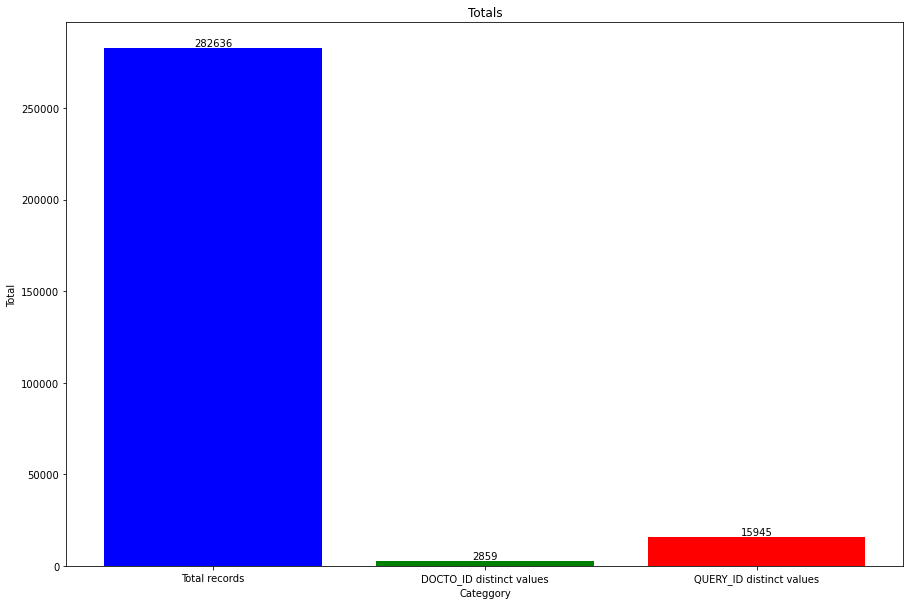

In [18]:
# Calcular os valores
total_registros = len(df)
valores_distintos_docto = df['DOC_ID'].nunique()
valores_distintos_query = df['QUERY_ID'].nunique()

# Criar os rótulos das barras
labels = ['Total records', 'DOCTO_ID distinct values', 'QUERY_ID distinct values']

# Criar os valores das barras
valores = [total_registros, valores_distintos_docto, valores_distintos_query]

# Definir as cores das barras
cores = ['blue', 'green', 'red']

# Plotar o gráfico de barras
plt.figure(figsize=(15, 10))
plt.bar(labels, valores, color=cores)
plt.title('Totals')
plt.xlabel('Categgory')
plt.ylabel('Total')

# Adicionar os valores sobre as barras
for i, valor in enumerate(valores):
    plt.text(i, valor, str(valor), ha='center', va='bottom')

plt.show()


In [19]:
list_property = ['TYPE_RELEVANCE']
colors = ['blue', 'green', 'red']

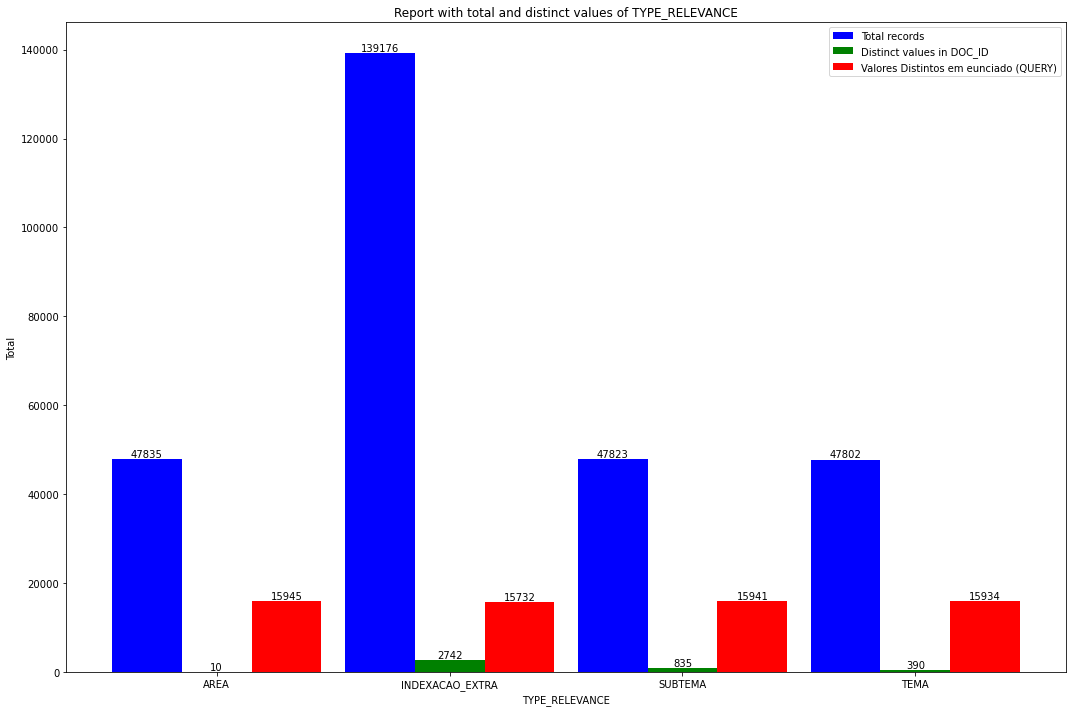

In [20]:

for property_name in list_property:
    # Agrupar o DataFrame por valor da propriedade
    grouped_data = df.groupby(property_name)

    # Calcular o total de registros, valores distintos em 'ID_DOCTO' e valores distintos em 'ID_QUERY' para cada valor da propriedade
    total_counts = grouped_data.size()
    distinct_counts_docto = grouped_data['DOC_ID'].nunique()
    distinct_counts_query = grouped_data['QUERY_ID'].nunique()

    # Obter os rótulos únicos
    labels = total_counts.index

    # Definir a largura das barras
    bar_width = 0.3

    # Calcular a posição das barras para cada label distinto
    positions = np.arange(len(labels))

    # Plotar o gráfico de barras
    plt.figure(figsize=(15, 10))

    # Plotar a primeira barra
    plt.bar(positions - bar_width, total_counts, width=bar_width, color=colors[0], label='Total records')

    # Plotar a segunda barra
    plt.bar(positions, distinct_counts_docto, width=bar_width, color=colors[1], label='Distinct values in DOC_ID')

    # Plotar a terceira barra
    plt.bar(positions + bar_width, distinct_counts_query, width=bar_width, color=colors[2], label='Valores Distintos em eunciado (QUERY)')

    plt.title(f'Report with total and distinct values of {property_name}')
    plt.xlabel(property_name)
    plt.ylabel('Total')
    plt.legend()

    # Adicionar rótulos com os valores em cada barra
    for i, label in enumerate(labels):
        plt.text(i-0.3, total_counts[i], str(total_counts[i]), ha='center', va='bottom')
        plt.text(i, distinct_counts_docto[i], str(distinct_counts_docto[i]), ha='center', va='bottom')
        plt.text(i+0.3, distinct_counts_query[i], str(distinct_counts_query[i]), ha='center', va='bottom')

    plt.xticks(ticks=positions, labels=labels)
    plt.tight_layout()
    plt.show()


In [21]:
PATH_LOCAL_DATA = '../data/juris_tcu_index'
PATH_DOC_DATA = f"{PATH_LOCAL_DATA}/doc.csv"

In [22]:
df_doc = pd.read_csv(PATH_DOC_DATA)

In [23]:
df_doc.head()

,TEXT,ID,NAME,DATE_REFERENCE,CLASS,HAS_SCOPE_NOTE,HAS_DEFINITION,HAS_SYNONYM,HAS_EXAMPLE,HAS_ENGLISH_TRANSLATION,HAS_SPECIALIZATION,HAS_RELATED_TERM,HAS_SPANISH_TRANSLATION,HAS_GENERALIZATION,TEXT_DEFINITION,TEXT_SYNONYM,TEXT_RELATED_TERM,TEXT_SCOPE_NOTE,TEXT_EXAMPLE,TEXT_ENGLISH_TRANSLATION,TEXT_SPANISH_TRANSLATION,TEXT_SPECIALIZATION,TEXT_GENERALIZATION,COUNT_INDEX_AREA,COUNT_INDEX_THEME,COUNT_INDEX_SUBTHEME,COUNT_INDEX_EXTRA,COUNT_INDEX_TOTAL
0,"O termo é ""Abandono de cargo"".\nAbandono de cargo tem definição: ""Configura abandono de cargo a ...",1,Abandono de cargo,20230614,Termo,1,1,1,0,1,0,1,1,0,Configura abandono de cargo a ausência intencional do servidor ao serviço por mais de trinta dia...,Abandono de função e Abandono do cargo.,"Abandono de emprego, Deserção, Falta grave, Função pública, Demissão de servidor, Inassiduidade ...",Artigo 323 Código Penal,NaN,Abandonment of office.,Abandono de puesto.,NaN,NaN,0,1,0,0,1
1,"O termo é ""Abastecimento de tropas e meios"".\nAbastecimento de tropas e meios é uma especializaç...",2,Abastecimento de tropas e meios,20230614,Termo,0,0,0,0,1,0,0,1,1,NaN,NaN,NaN,NaN,NaN,Supply of troops and means.,Abastecimiento de tropas y medios e Suministro de tropas y médios.,Abastecimento.,NaN,0,0,0,1,1
2,"O termo é ""Tropa"".\nTropa tem definição: ""Termo coletivo que designa o pessoal de uma organizaçã...",3,Tropa,20230614,Termo,0,1,0,0,1,0,1,1,0,Termo coletivo que designa o pessoal de uma organização militar.,NaN,Organização militar e Missão.,NaN,NaN,Troop.,Tropa.,NaN,NaN,0,0,0,0,0
3,"O termo é ""Abono de faltas"".\nAbono de faltas tem definição: ""É a relevação da falta, de forma q...",4,Abono de faltas,20230614,Termo,1,1,1,0,0,0,1,0,0,"É a relevação da falta, de forma que o servidor não sofra qualquer desconto pelo dia não trabalh...","Faltas, Abono das faltas e Abono de ausências.",Inassiduidade habitual e Afastamento de pessoal.,Usado para servidores regidos pela CLT (art. 473).,NaN,NaN,NaN,NaN,NaN,0,0,0,1,1
4,"O termo é ""Abono de permanência em serviço"".\nAbono de permanência em serviço tem definição: ""O ...",5,Abono de permanência em serviço,20230614,Termo,0,1,1,0,0,0,1,0,0,O abono de permanência será pago ao servidor que tiver preenchido as exigências para aposentador...,"Abono de permanência, Adicional de permanência e Abono permanência.","Aposentadoria voluntária, Contribuição previdenciária e Regime Próprio de Previdência Social.",NaN,NaN,NaN,NaN,NaN,NaN,0,7,0,4,11


In [24]:
df.shape

(282636, 6)

In [25]:
df = df.merge(df_doc[['ID','NAME']], how='left', left_on='DOC_ID', right_on='ID').drop(['ID'],axis=1)

In [26]:
df.shape

(282636, 7)

In [27]:
df['TYPE_RELEVANCE'].unique()

array(['AREA', 'TEMA', 'SUBTEMA', 'INDEXACAO_EXTRA'], dtype=object)

In [28]:
list_property = list(df['TYPE_RELEVANCE'].unique())

In [30]:
df.groupby(['TYPE_RELEVANCE','RELEVANCE'])['DOC_ID'].agg(['count','nunique'])

count  nunique
TYPE_RELEVANCE  RELEVANCE                
AREA            0          31890       10
                1          15945       10
INDEXACAO_EXTRA 0          92784     2293
                1          46392     2740
SUBTEMA         0          31882      755
                1          15941      833
TEMA            0          31868      373
                1          15934      390

In [31]:
df.columns

Index(['QUERY_ID', 'DOC_ID', 'RELEVANCE', 'TYPE_RELEVANCE', 'DOC_TEXT', 'QUERY_TEXT', 'NAME'], dtype='object')

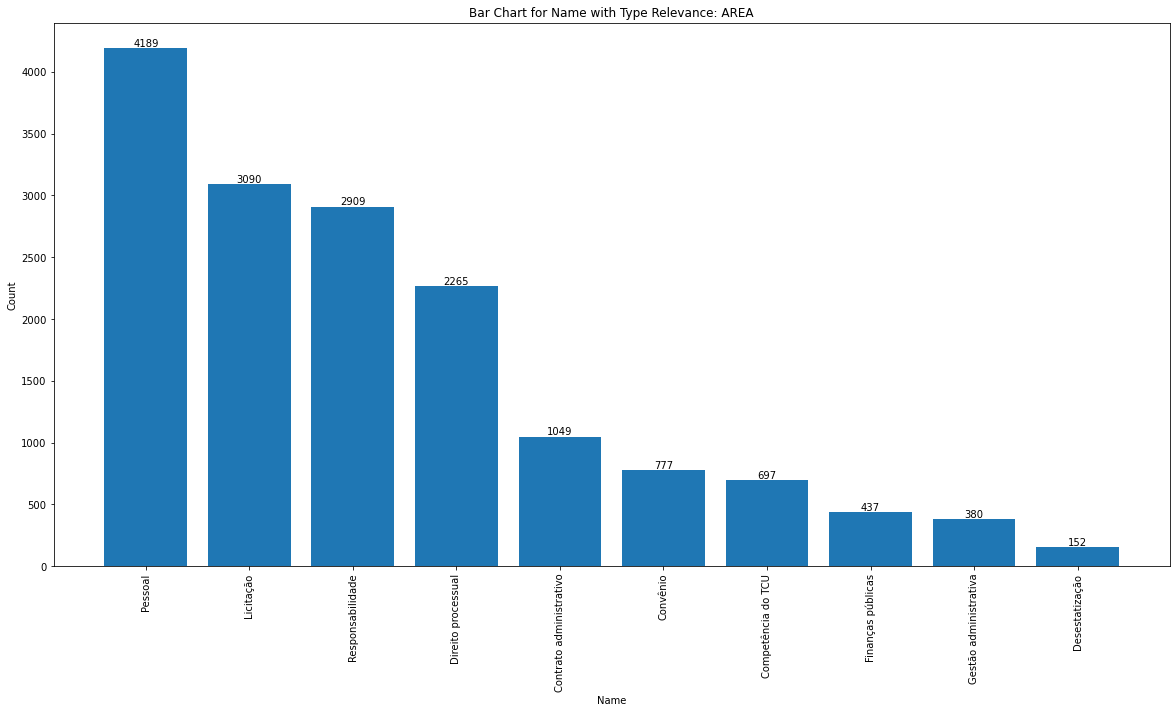

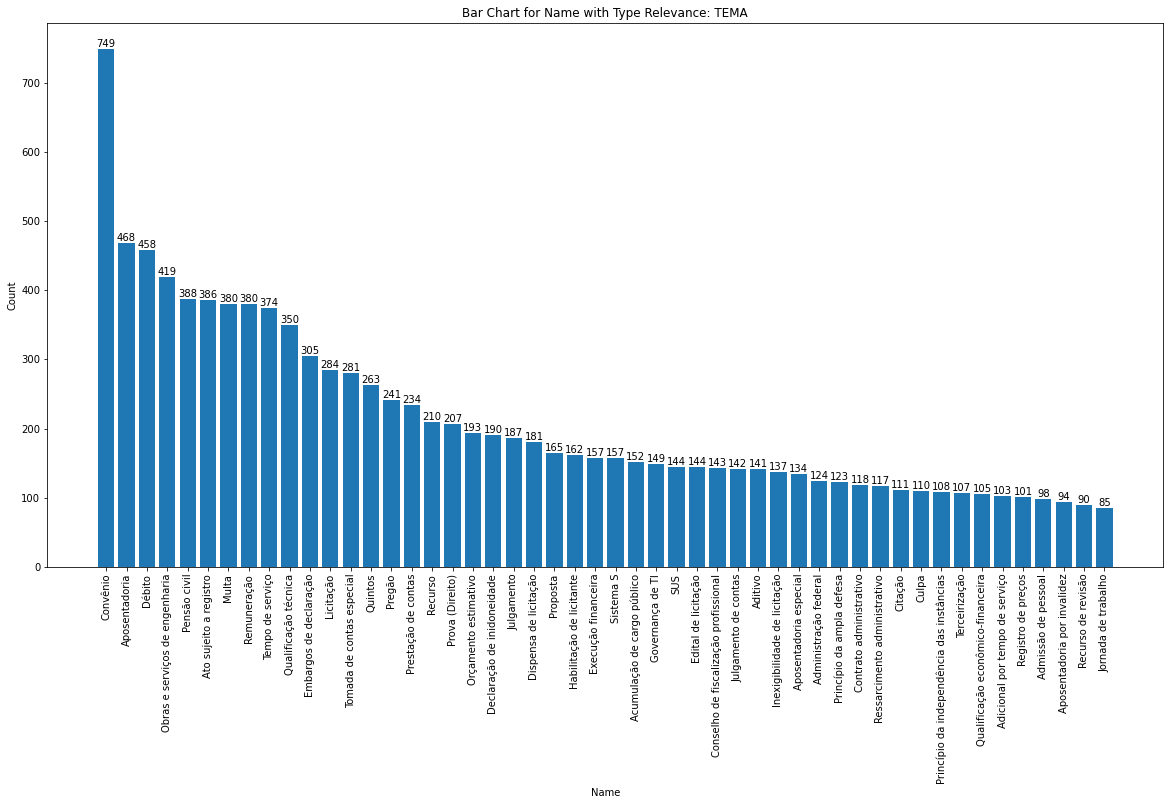

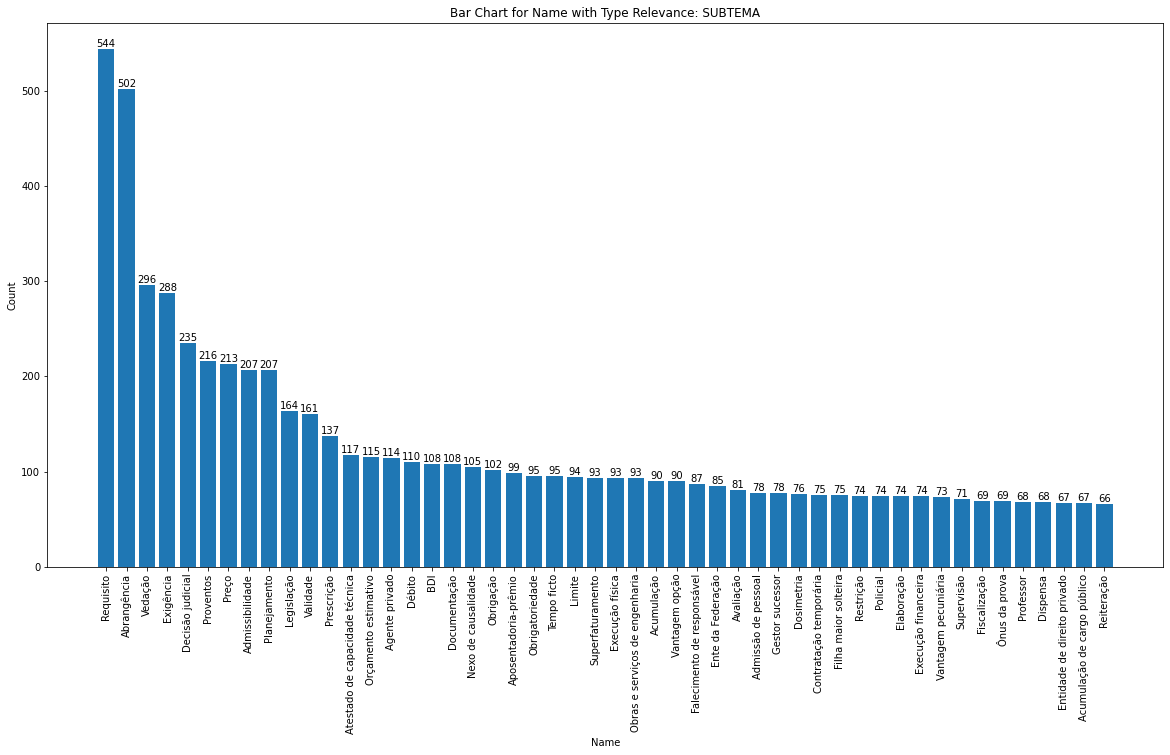

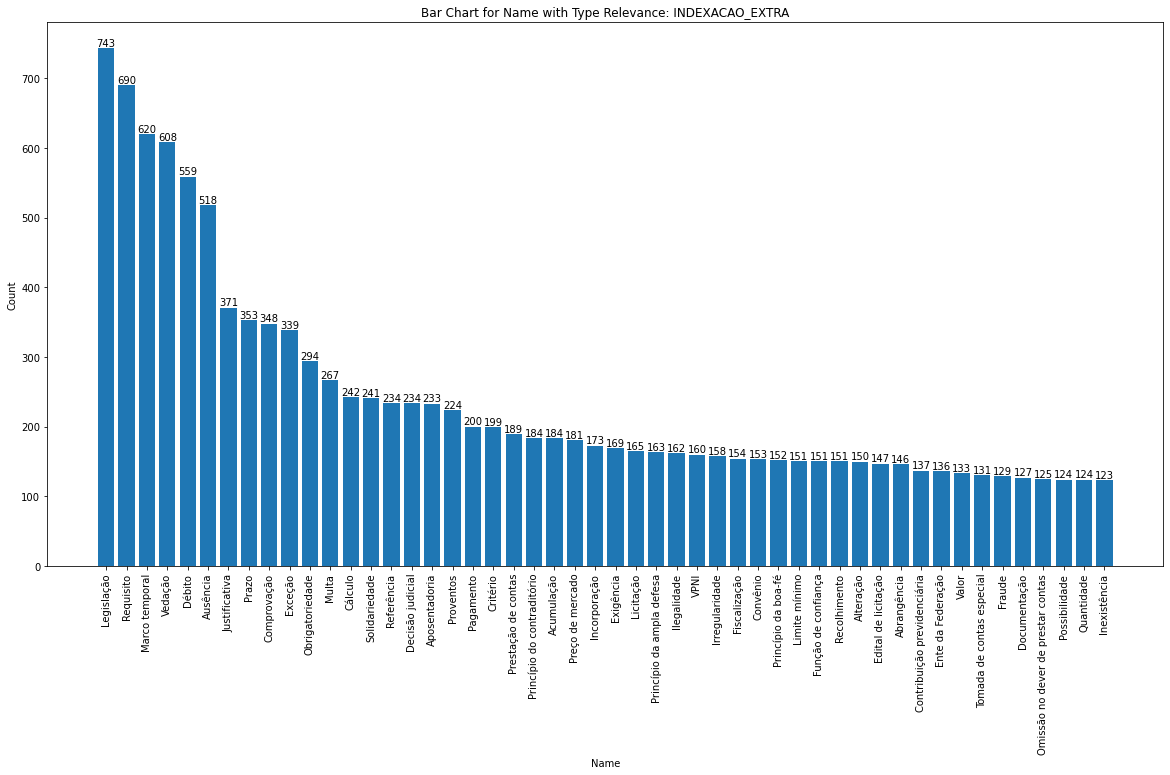

In [32]:
import matplotlib.pyplot as plt

# Iterate over each property value in list_property
for property in list_property:
    if property == 'AREA':
        top_k = 10
    else:
        top_k = 50

    # Filter the DataFrame for the given property value in TYPE_RELEVANCE
    filtered_df = df[(df['TYPE_RELEVANCE'] == property) & (df['RELEVANCE']==1) ]
    
    # Group by "name" and count the occurrences
    name_counts = filtered_df['NAME'].value_counts().head(top_k)
    plt.figure(figsize=(20, 10))
    
    # Create the bar chart
    bars = plt.bar(name_counts.index, name_counts.values)
    
    # Set the labels and title
    plt.xlabel('Name')
    plt.ylabel('Count')
    plt.title(f'Bar Chart for Name with Type Relevance: {property}')
    
    # Rotate the x-axis labels for better visibility if needed
    plt.xticks(rotation=90)
    
    # Print the number on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
    
    # Display the chart
    plt.show()


In [33]:
from tqdm import tqdm

In [34]:
%%time
# Define o número máximo de registros com relevância e sem relevância por par type_relevance e doc_id
max_relevant_records = 200
max_irrelevant_records = 200

# Cria uma lista para armazenar os dataframes balanceados
balanced_dfs = []

# Itera sobre cada par type_relevance e doc_id
for type_relevance, doc_id in tqdm(df.groupby(['TYPE_RELEVANCE', 'DOC_ID'])):
    # Filtra os registros relevantes e não relevantes
    relevant_records = df[(df['TYPE_RELEVANCE'] == type_relevance) & (df['DOC_ID'] == doc_id) & (df['RELEVANCE'] == 1)].sample(n=max_relevant_records, random_state=42)
    irrelevant_records = df[(df['TYPE_RELEVANCE'] == type_relevance) & (df['DOC_ID'] == doc_id) & (df['RELEVANCE'] == 0)].sample(n=max_irrelevant_records, random_state=42)
    
    # Combina os registros relevantes e não relevantes em um novo dataframe
    balanced_df = pd.concat([relevant_records, irrelevant_records])
    
    # Adiciona o dataframe balanceado à lista
    balanced_dfs.append(balanced_df)

# Combina todos os dataframes balanceados em um único dataframe
df_balanced = pd.concat(balanced_dfs)


  0%|          | 0/3977 [00:00<?, ?it/s]/home/borela/miniconda3/envs/relevar-busca/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  # This is added back by InteractiveShellApp.init_path()
  0%|          | 0/3977 [03:06<?, ?it/s]


MemoryError: Unable to allocate 595. GiB for an array with shape (282643, 282636) and data type object

In [35]:
%%time
# Define o número máximo de registros com relevância e sem relevância por par type_relevance e doc_id
max_relevant_records = 200
max_irrelevant_records = 200

# Cria uma lista para armazenar os dataframes balanceados
balanced_dfs = []

# Itera sobre cada par type_relevance e doc_id
for (type_relevance, doc_id), group_df in df.groupby(['TYPE_RELEVANCE', 'DOC_ID']):
    # Filtra os registros relevantes e não relevantes
    relevant_records = group_df[group_df['RELEVANCE'] == 1].sample(n=max_relevant_records, random_state=42)
    irrelevant_records = group_df[group_df['RELEVANCE'] == 0].sample(n=max_irrelevant_records, random_state=42)
    
    # Combina os registros relevantes e não relevantes em um novo dataframe
    balanced_df = pd.concat([relevant_records, irrelevant_records])
    
    # Adiciona o dataframe balanceado à lista
    balanced_dfs.append(balanced_df)

# Combina todos os dataframes balanceados em um único dataframe
df_balanced = pd.concat(balanced_dfs)


ValueError: Cannot take a larger sample than population when 'replace=False'

In [36]:
%%time
# Define o número máximo de registros com relevância e sem relevância por par type_relevance e doc_id
max_relevant_records = 200
max_irrelevant_records = 200

# Cria uma lista para armazenar os dataframes balanceados
balanced_dfs = []

# Itera sobre cada par type_relevance e doc_id
for (type_relevance, doc_id), group_df in df.groupby(['TYPE_RELEVANCE', 'DOC_ID']):
    # Filtra os registros relevantes e não relevantes
    relevant_records = group_df[group_df['RELEVANCE'] == 1]
    irrelevant_records = group_df[group_df['RELEVANCE'] == 0]
    
    # Verifica se há registros suficientes para cada categoria
    num_relevant_records = len(relevant_records)
    num_irrelevant_records = len(irrelevant_records)
    
    if num_relevant_records >= max_relevant_records and num_irrelevant_records >= max_irrelevant_records:
        # Seleciona aleatoriamente o número desejado de registros relevantes e não relevantes
        relevant_records = relevant_records.sample(n=max_relevant_records, random_state=42)
        irrelevant_records = irrelevant_records.sample(n=max_irrelevant_records, random_state=42)
    else:
        # Define o número de amostras como o tamanho máximo disponível
        max_relevant_records = min(max_relevant_records, num_relevant_records)
        max_irrelevant_records = min(max_irrelevant_records, num_irrelevant_records)
        relevant_records = relevant_records.sample(n=max_relevant_records, random_state=42)
        irrelevant_records = irrelevant_records.sample(n=max_irrelevant_records, random_state=42)
    
    # Combina os registros relevantes e não relevantes em um novo dataframe
    balanced_df = pd.concat([relevant_records, irrelevant_records])
    
    # Adiciona o dataframe balanceado à lista
    balanced_dfs.append(balanced_df)

# Combina todos os dataframes balanceados em um único dataframe
df_balanced = pd.concat(balanced_dfs)


CPU times: user 4.9 s, sys: 19.9 ms, total: 4.92 s
Wall time: 4.92 s


In [38]:
import pandas as pd

# Define o número máximo de registros com relevância e sem relevância por par type_relevance e doc_id
max_records = 200

# Cria uma lista para armazenar os dataframes balanceados
balanced_dfs = []

# Itera sobre cada par type_relevance e doc_id
for (type_relevance, doc_id), group_df in df.groupby(['TYPE_RELEVANCE', 'DOC_ID']):
    # Filtra os registros relevantes e não relevantes
    relevant_records = group_df[group_df['RELEVANCE'] == 1]
    irrelevant_records = group_df[group_df['RELEVANCE'] == 0]
    
    # Verifica o número de registros relevantes e não relevantes
    num_relevant_records = len(relevant_records)
    num_irrelevant_records = len(irrelevant_records)
    
    # Define o número máximo de registros com base na disponibilidade
    max_relevant_records = min(num_relevant_records, max_records)
    max_irrelevant_records = min(num_irrelevant_records, max_records)
    
    # Seleciona os registros relevantes e não relevantes
    if num_relevant_records <= max_records:
        relevant_selected = relevant_records
    else:
        relevant_selected = relevant_records.sample(n=max_relevant_records, random_state=42)
    
    if num_irrelevant_records <= max_records:
        irrelevant_selected = irrelevant_records
    else:
        irrelevant_selected = irrelevant_records.sample(n=max_irrelevant_records, random_state=42)
    
    # Combina os registros relevantes e não relevantes em um novo dataframe
    balanced_df = pd.concat([relevant_selected, irrelevant_selected])
    
    # Adiciona o dataframe balanceado à lista
    balanced_dfs.append(balanced_df)

# Combina todos os dataframes balanceados em um único dataframe
df_balanced = pd.concat(balanced_dfs)


In [39]:
df_balanced.shape

(203355, 7)

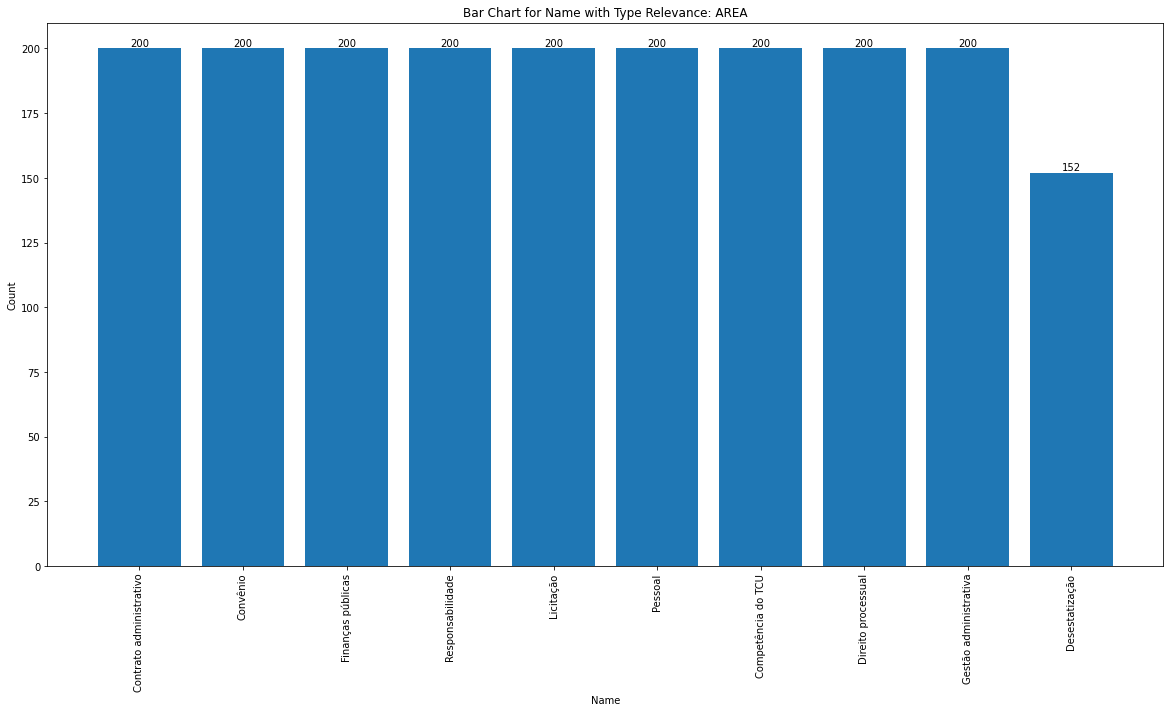

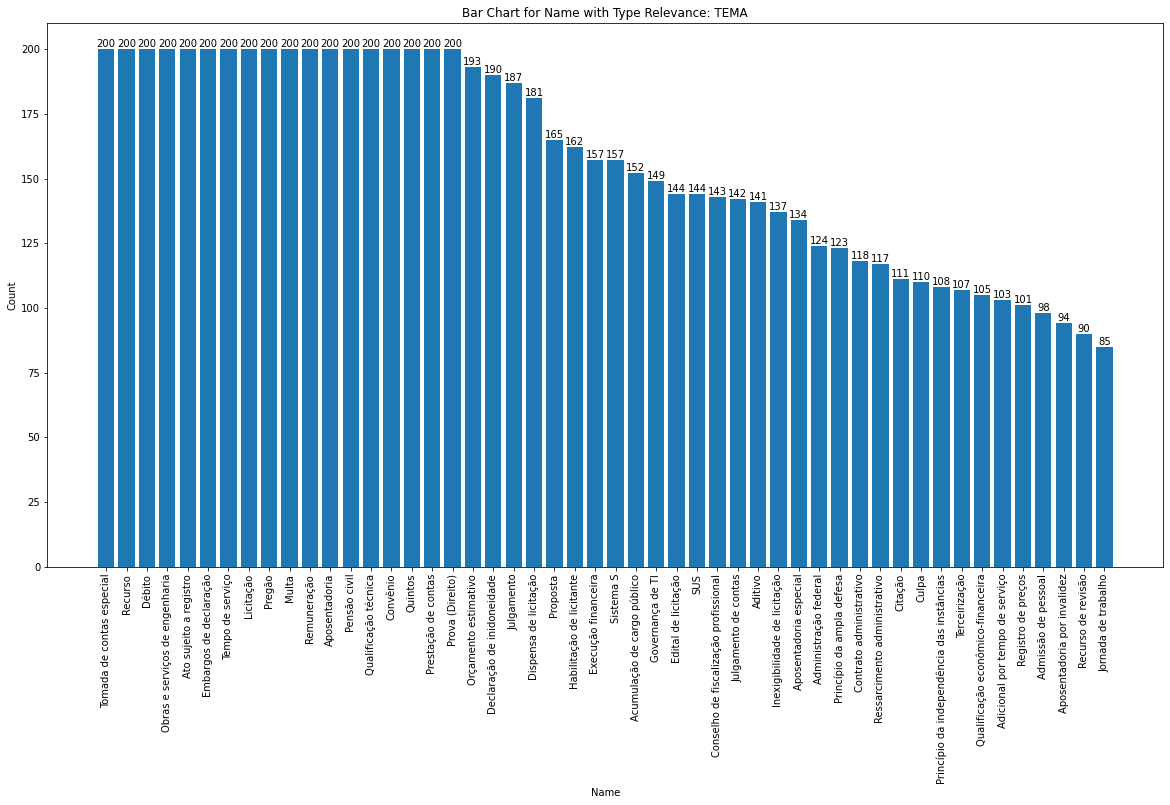

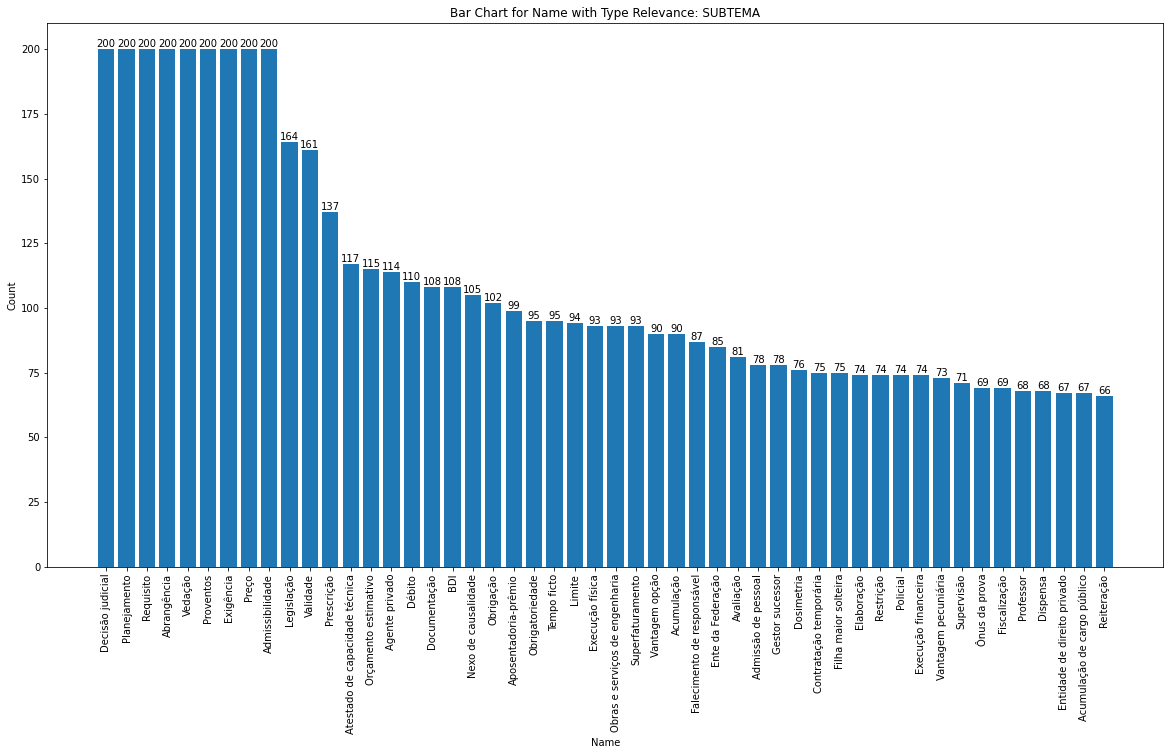

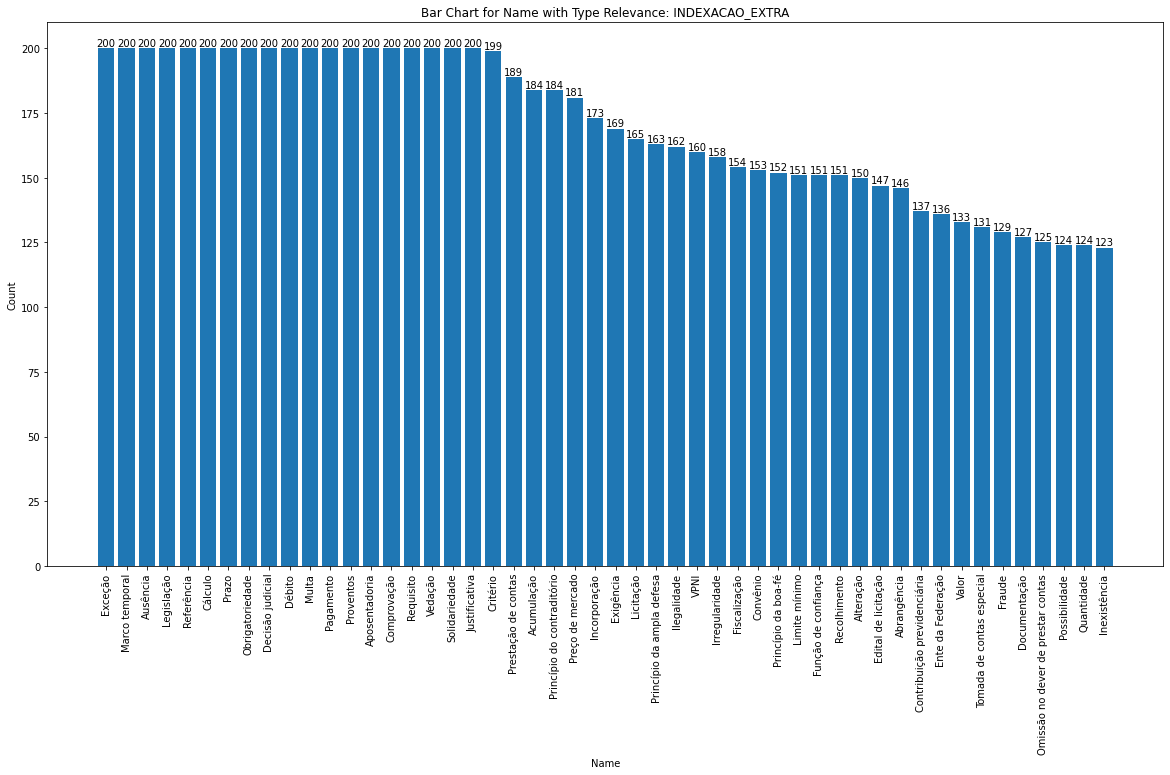

In [40]:

# Iterate over each property value in list_property
for property in list_property:
    if property == 'AREA':
        top_k = 10
    else:
        top_k = 50

    # Filter the DataFrame for the given property value in TYPE_RELEVANCE
    filtered_df_balanced = df_balanced[(df_balanced['TYPE_RELEVANCE'] == property) & (df_balanced['RELEVANCE']==1) ]
    
    # Group by "name" and count the occurrences
    name_counts = filtered_df_balanced['NAME'].value_counts().head(top_k)
    plt.figure(figsize=(20, 10))
    
    # Create the bar chart
    bars = plt.bar(name_counts.index, name_counts.values)
    
    # Set the labels and title
    plt.xlabel('Name')
    plt.ylabel('Count')
    plt.title(f'Bar Chart for Name with Type Relevance: {property}')
    
    # Rotate the x-axis labels for better visibility if needed
    plt.xticks(rotation=90)
    
    # Print the number on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
    
    # Display the chart
    plt.show()


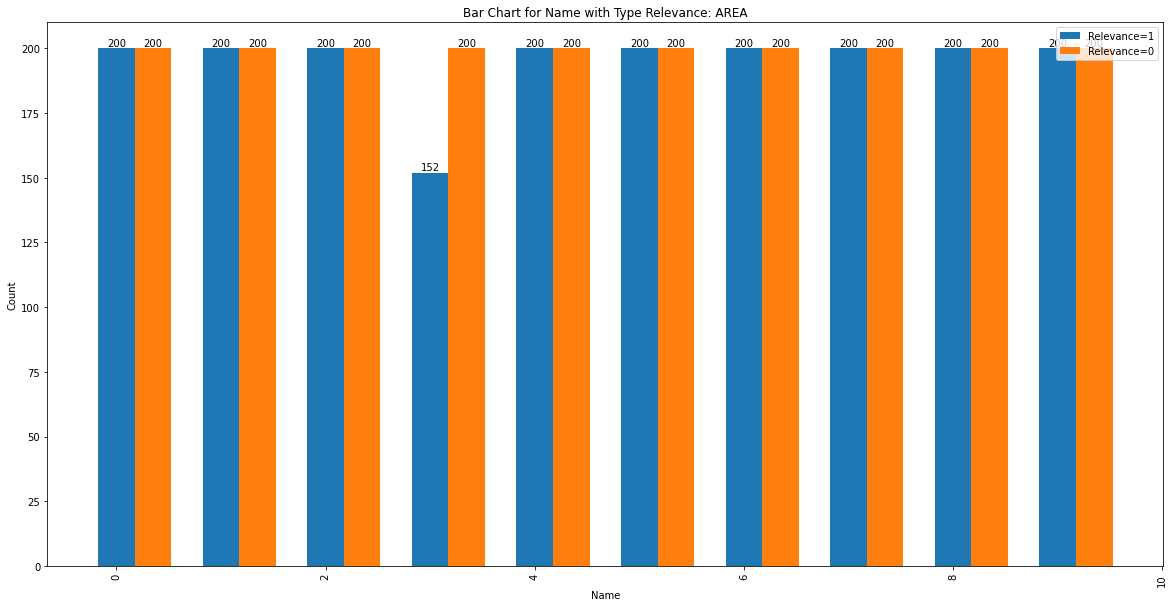

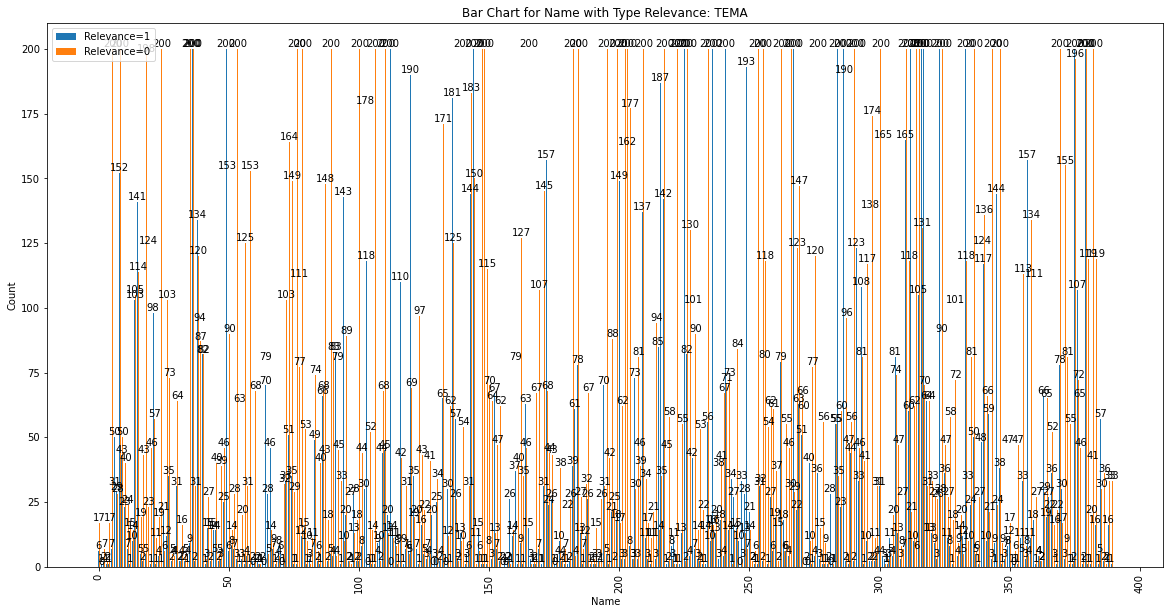

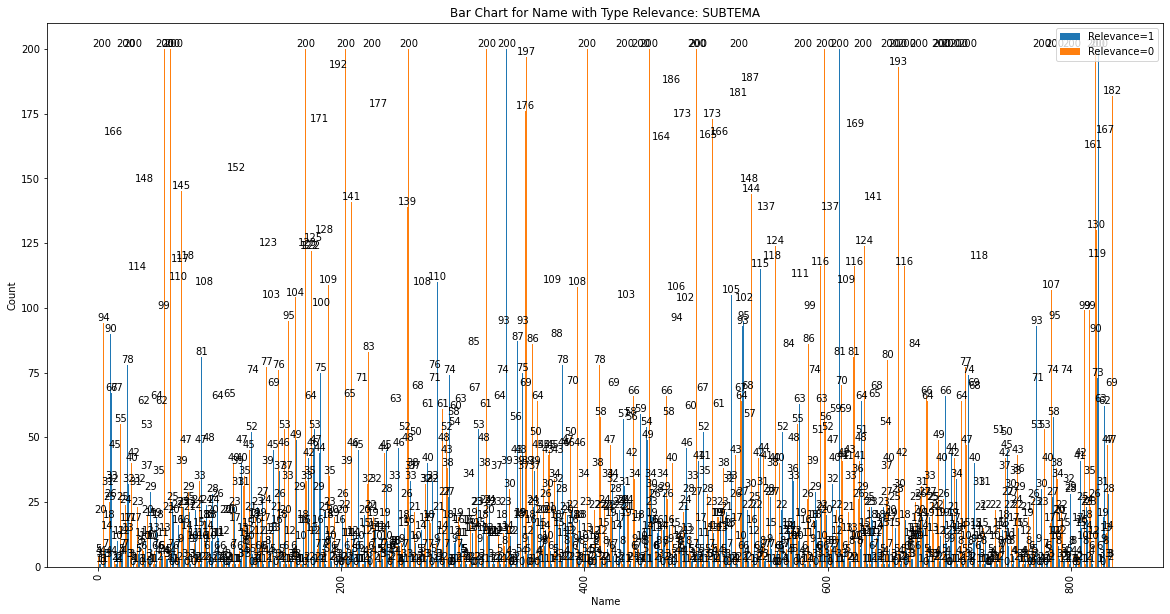

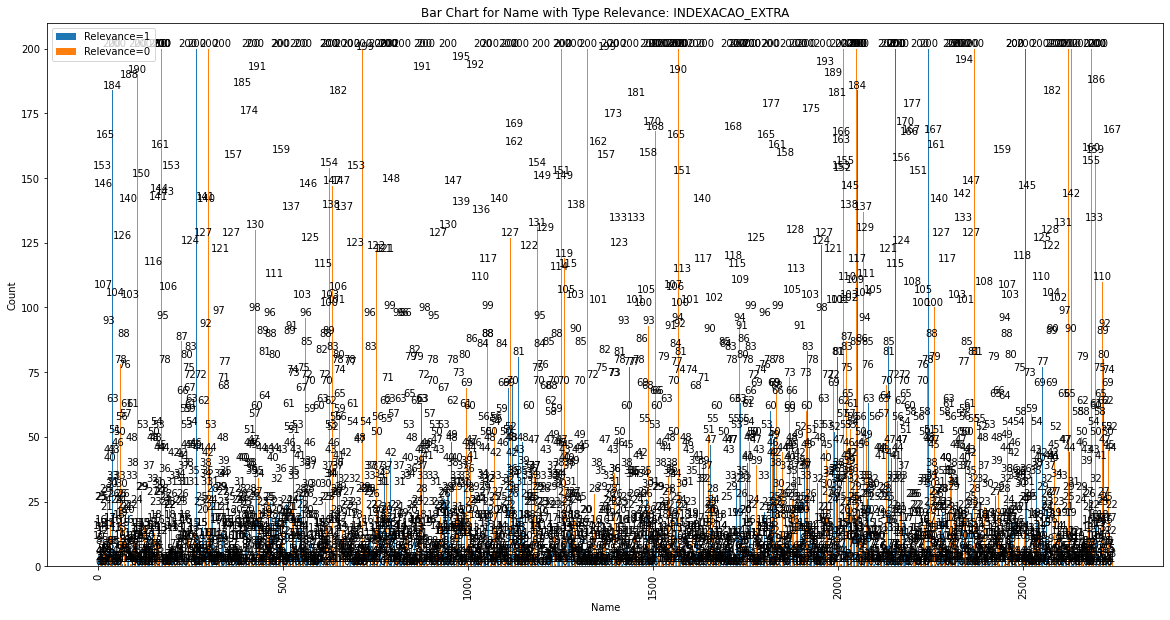

In [41]:
import numpy as np

# Iterate over each property value in list_property
for property in list_property:
    if property == 'AREA':
        top_k = 10
    else:
        top_k = 20

    # Filter the DataFrame for the given property value in TYPE_RELEVANCE and relevance==1
    filtered_df_balanced_relevant = df_balanced[(df_balanced['TYPE_RELEVANCE'] == property) & (df_balanced['RELEVANCE'] == 1)]
    
    # Filter the DataFrame for the given property value in TYPE_RELEVANCE and relevance==0
    filtered_df_balanced_irrelevant = df_balanced[(df_balanced['TYPE_RELEVANCE'] == property) & (df_balanced['RELEVANCE'] == 0)]
    
    # Get the unique names from the relevant and irrelevant dataframes
    unique_names_relevant = filtered_df_balanced_relevant['NAME'].unique()
    unique_names_irrelevant = filtered_df_balanced_irrelevant['NAME'].unique()
    
    # Combine the unique names from both dataframes
    unique_names = np.union1d(unique_names_relevant, unique_names_irrelevant)
    
    # Calculate the count of each name in the relevant and irrelevant dataframes
    relevant_counts = filtered_df_balanced_relevant['NAME'].value_counts().reindex(unique_names, fill_value=0)
    irrelevant_counts = filtered_df_balanced_irrelevant['NAME'].value_counts().reindex(unique_names, fill_value=0)
    
    # Set the width for each bar
    bar_width = 0.35
    
    # Create the x-axis positions for the bars
    x = np.arange(len(unique_names))
    
    # Create the bar chart
    plt.figure(figsize=(20, 10))
    bars_relevant = plt.bar(x, relevant_counts, width=bar_width, label='Relevance=1')
    bars_irrelevant = plt.bar(x + bar_width, irrelevant_counts, width=bar_width, label='Relevance=0')
    
    # Set the labels and title
    plt.xlabel('Name')
    plt.ylabel('Count')
    plt.title(f'Bar Chart for Name with Type Relevance: {property}')
    
    # Rotate the x-axis labels for better visibility if needed
    plt.xticks(rotation=90)
    
    # Print the number on top of each bar for relevance=1
    for bar in bars_relevant:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
    
    # Print the number on top of each bar for relevance=0
    for bar in bars_irrelevant:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
    
    # Add a legend
    plt.legend()
    
    # Display the chart
    plt.show()


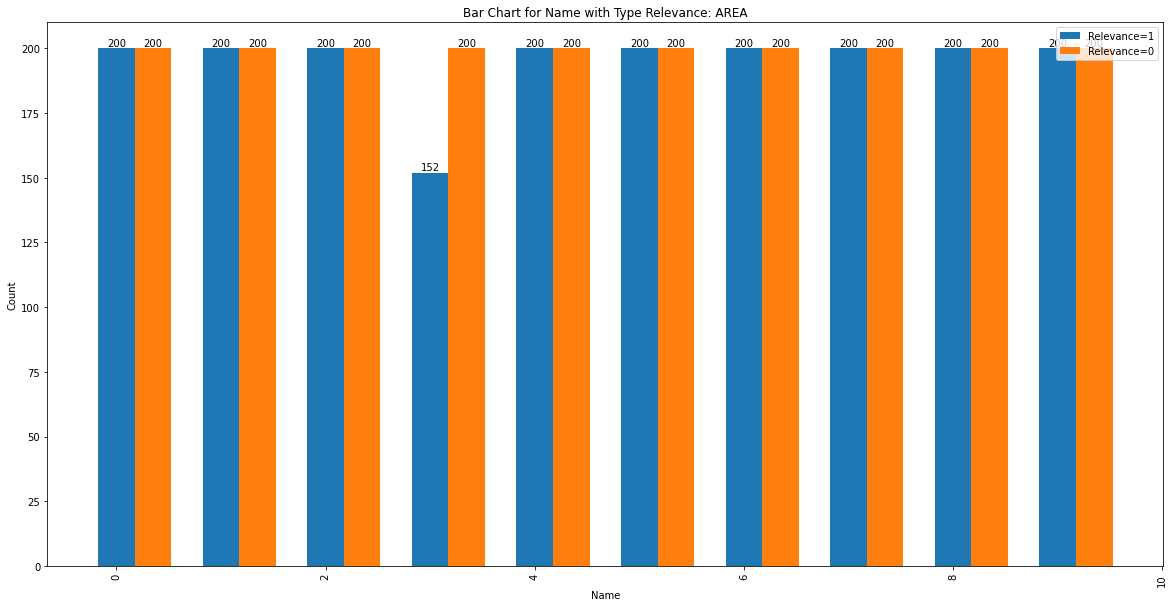

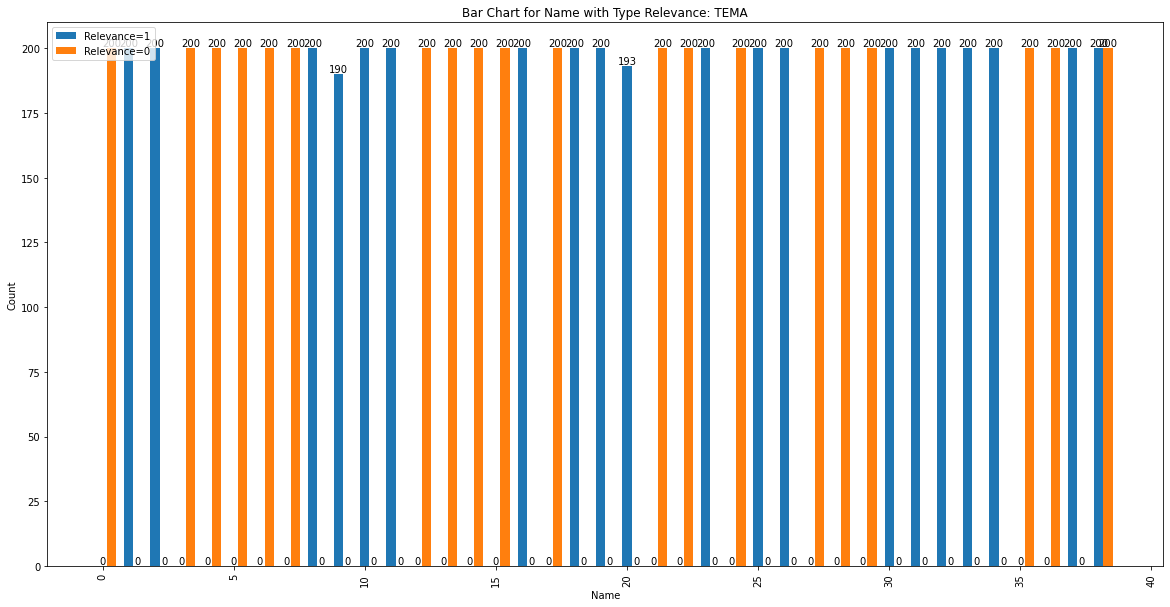

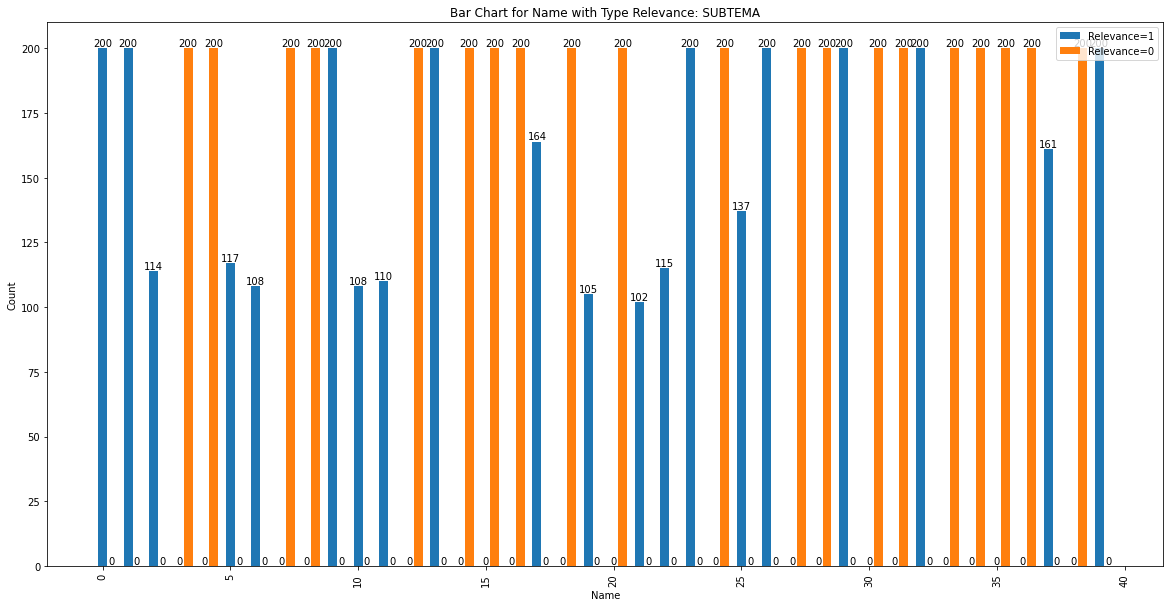

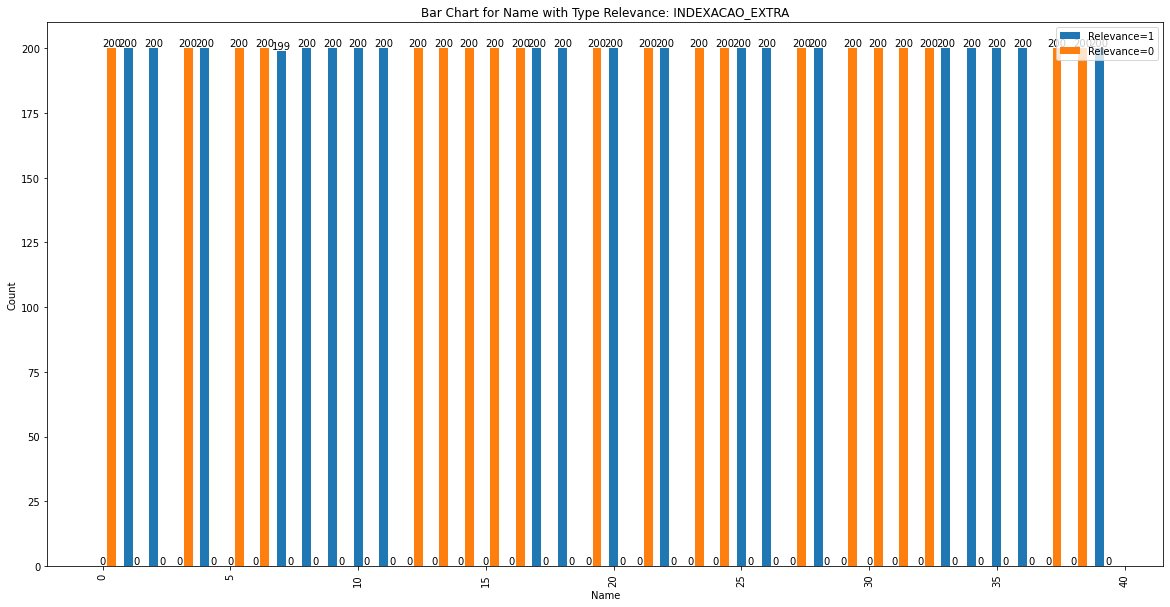

In [42]:
import numpy as np

# Iterate over each property value in list_property
for property in list_property:
    if property == 'AREA':
        top_k = 10
    else:
        top_k = 20

    # Filter the DataFrame for the given property value in TYPE_RELEVANCE and relevance==1
    filtered_df_balanced_relevant = df_balanced[(df_balanced['TYPE_RELEVANCE'] == property) & (df_balanced['RELEVANCE'] == 1)]
    
    # Filter the DataFrame for the given property value in TYPE_RELEVANCE and relevance==0
    filtered_df_balanced_irrelevant = df_balanced[(df_balanced['TYPE_RELEVANCE'] == property) & (df_balanced['RELEVANCE'] == 0)]
    
    # Get the top_k names with the highest counts in the relevant dataframe
    top_relevant_names = filtered_df_balanced_relevant['NAME'].value_counts().head(top_k)
    
    # Get the top_k names with the highest counts in the irrelevant dataframe
    top_irrelevant_names = filtered_df_balanced_irrelevant['NAME'].value_counts().head(top_k)
    
    # Combine the unique names from both dataframes
    unique_names = np.union1d(top_relevant_names.index, top_irrelevant_names.index)
    
    # Calculate the count of each name in the relevant and irrelevant dataframes
    relevant_counts = top_relevant_names.reindex(unique_names, fill_value=0)
    irrelevant_counts = top_irrelevant_names.reindex(unique_names, fill_value=0)
    
    # Set the width for each bar
    bar_width = 0.35
    
    # Create the x-axis positions for the bars
    x = np.arange(len(unique_names))
    
    # Create the bar chart
    plt.figure(figsize=(20, 10))
    bars_relevant = plt.bar(x, relevant_counts, width=bar_width, label='Relevance=1')
    bars_irrelevant = plt.bar(x + bar_width, irrelevant_counts, width=bar_width, label='Relevance=0')
    
    # Set the labels and title
    plt.xlabel('Name')
    plt.ylabel('Count')
    plt.title(f'Bar Chart for Name with Type Relevance: {property}')
    
    # Rotate the x-axis labels for better visibility if needed
    plt.xticks(rotation=90)
    
    # Print the number on top of each bar for relevance=1
    for bar in bars_relevant:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
    
    # Print the number on top of each bar for relevance=0
    for bar in bars_irrelevant:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
    
    # Add a legend
    plt.legend()
    
    # Display the chart
    plt.show()


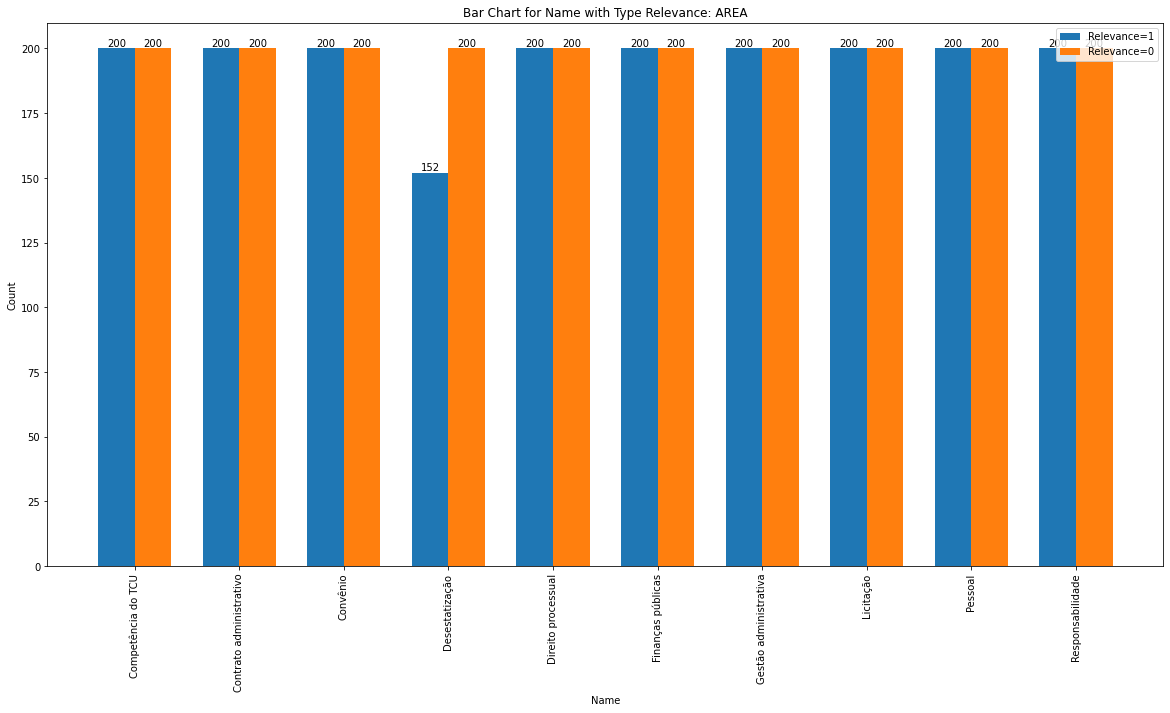

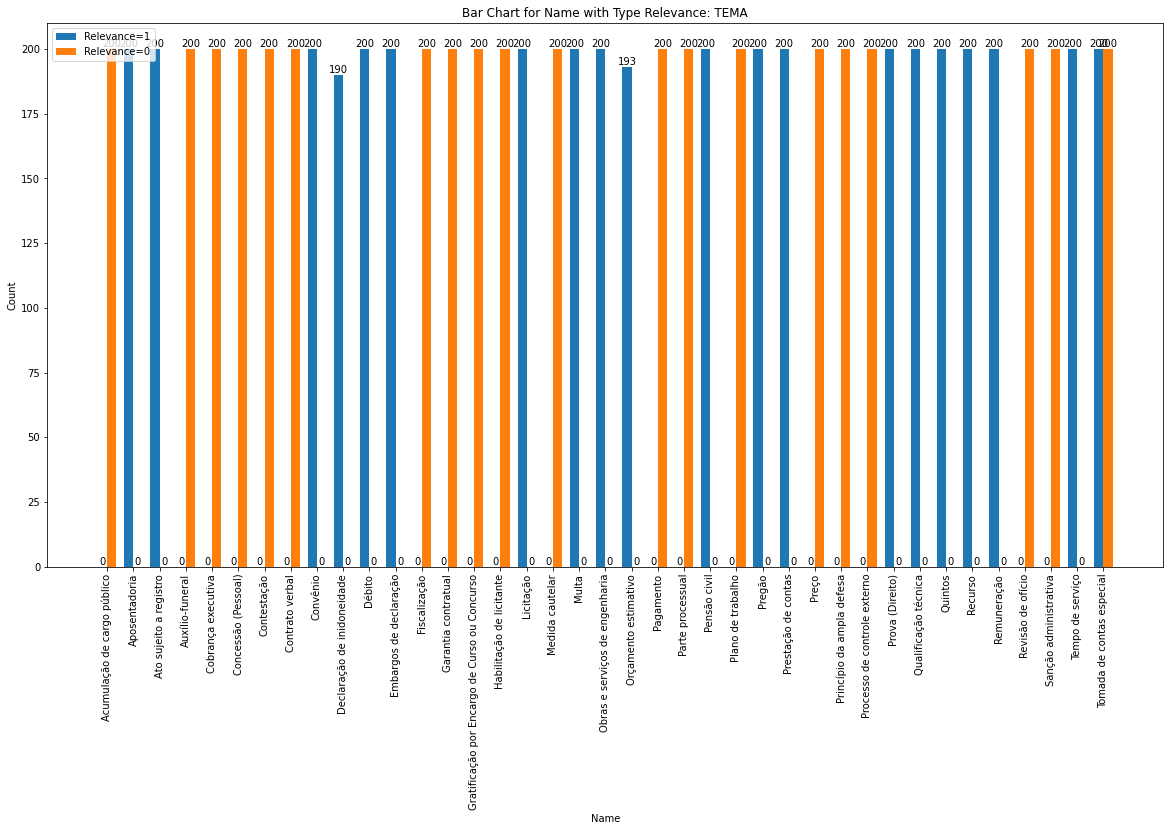

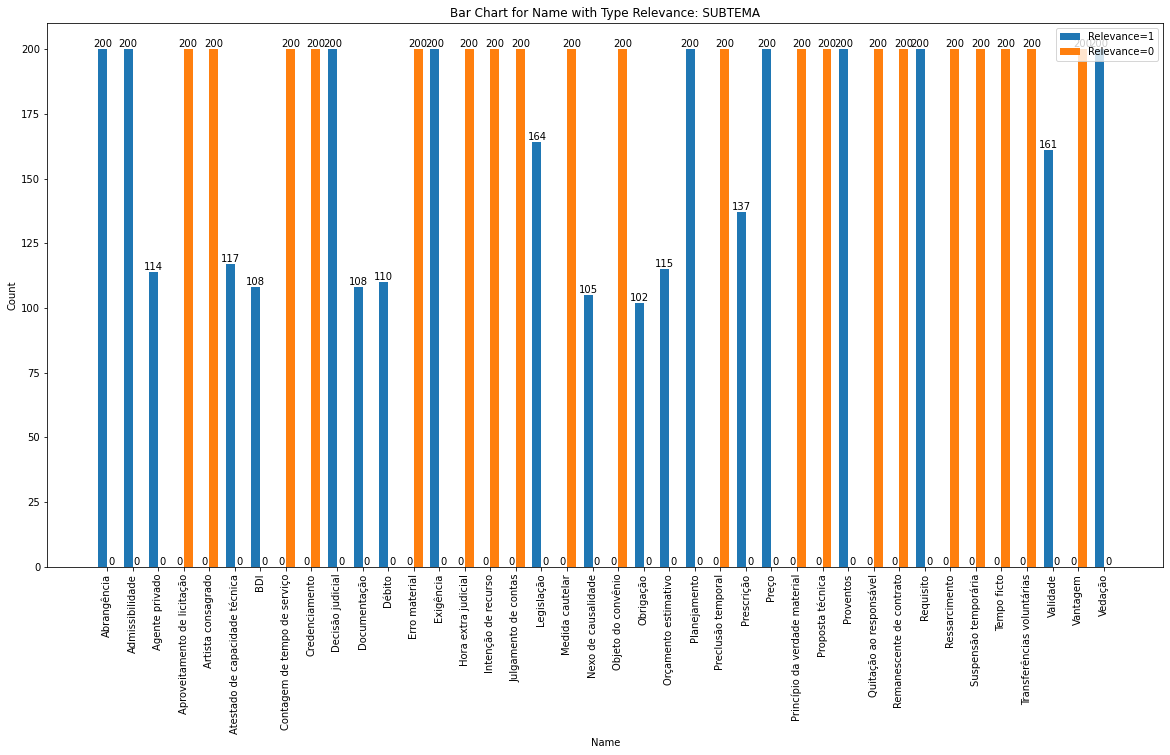

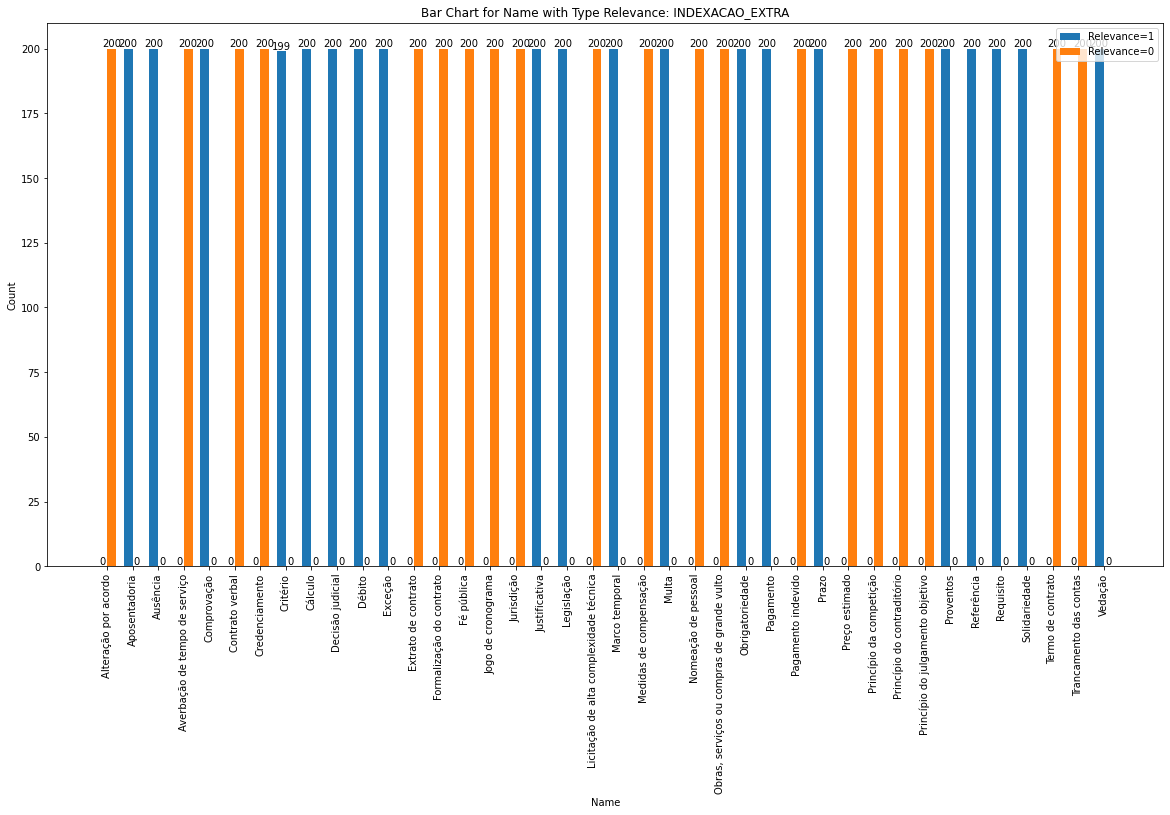

In [43]:
import numpy as np

# Iterate over each property value in list_property
for property in list_property:
    if property == 'AREA':
        top_k = 10
    else:
        top_k = 20

    # Filter the DataFrame for the given property value in TYPE_RELEVANCE and relevance==1
    filtered_df_balanced_relevant = df_balanced[(df_balanced['TYPE_RELEVANCE'] == property) & (df_balanced['RELEVANCE'] == 1)]
    
    # Filter the DataFrame for the given property value in TYPE_RELEVANCE and relevance==0
    filtered_df_balanced_irrelevant = df_balanced[(df_balanced['TYPE_RELEVANCE'] == property) & (df_balanced['RELEVANCE'] == 0)]
    
    # Get the top_k names with the highest counts in the relevant dataframe
    top_relevant_names = filtered_df_balanced_relevant['NAME'].value_counts().head(top_k)
    
    # Get the top_k names with the highest counts in the irrelevant dataframe
    top_irrelevant_names = filtered_df_balanced_irrelevant['NAME'].value_counts().head(top_k)
    
    # Combine the unique names from both dataframes
    unique_names = np.union1d(top_relevant_names.index, top_irrelevant_names.index)
    
    # Calculate the count of each name in the relevant and irrelevant dataframes
    relevant_counts = top_relevant_names.reindex(unique_names, fill_value=0)
    irrelevant_counts = top_irrelevant_names.reindex(unique_names, fill_value=0)
    
    # Set the width for each bar
    bar_width = 0.35
    
    # Create the x-axis positions for the bars
    x = np.arange(len(unique_names))
    
    # Create the bar chart
    plt.figure(figsize=(20, 10))
    bars_relevant = plt.bar(x, relevant_counts, width=bar_width, label='Relevance=1')
    bars_irrelevant = plt.bar(x + bar_width, irrelevant_counts, width=bar_width, label='Relevance=0')
    
    # Set the labels and title
    plt.xlabel('Name')
    plt.ylabel('Count')
    plt.title(f'Bar Chart for Name with Type Relevance: {property}')
    
    # Set the x-axis ticks to the names
    plt.xticks(x + bar_width / 2, unique_names, rotation=90)
    
    # Print the number on top of each bar for relevance=1
    for bar in bars_relevant:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
    
    # Print the number on top of each bar for relevance=0
    for bar in bars_irrelevant:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
    
    # Add a legend
    plt.legend()
    
    # Display the chart
    plt.show()


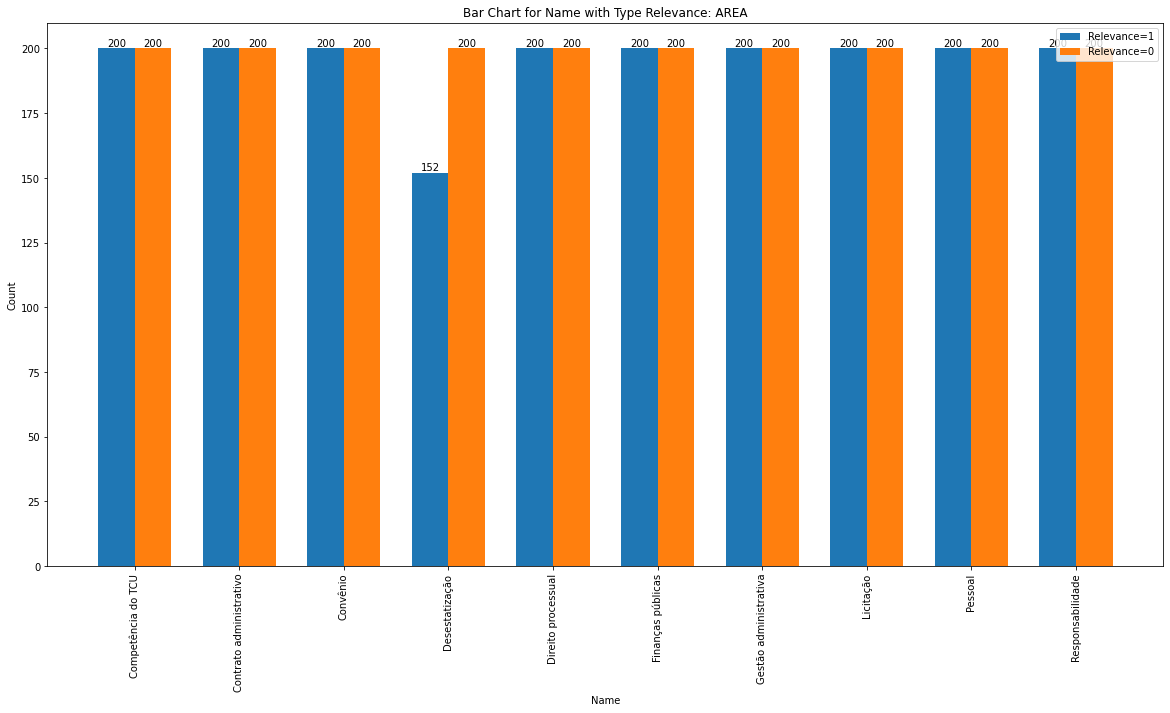

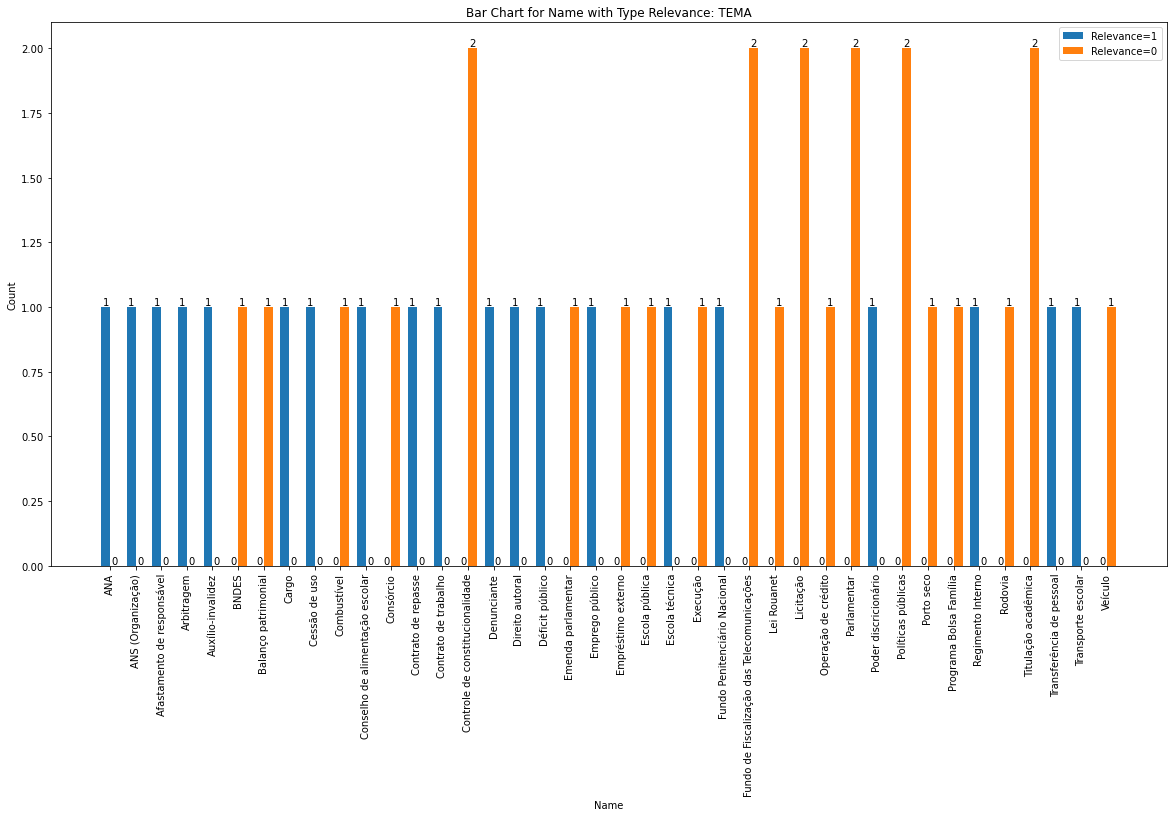

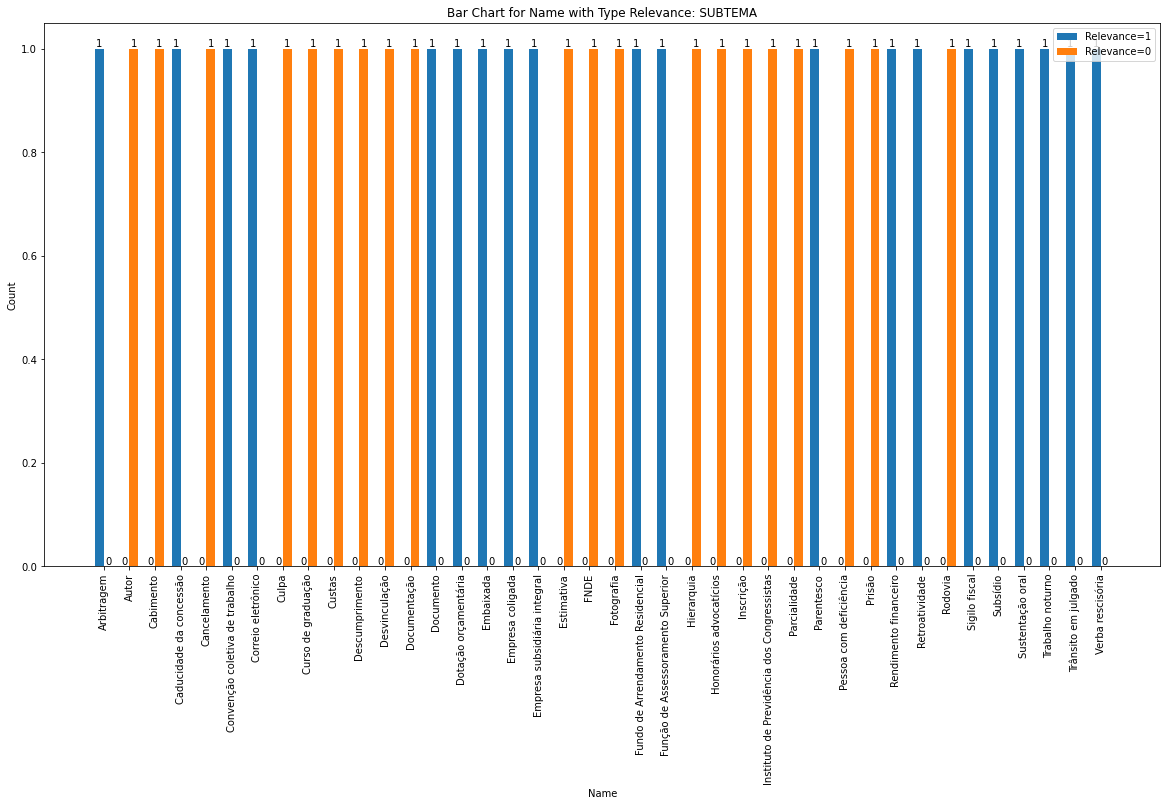

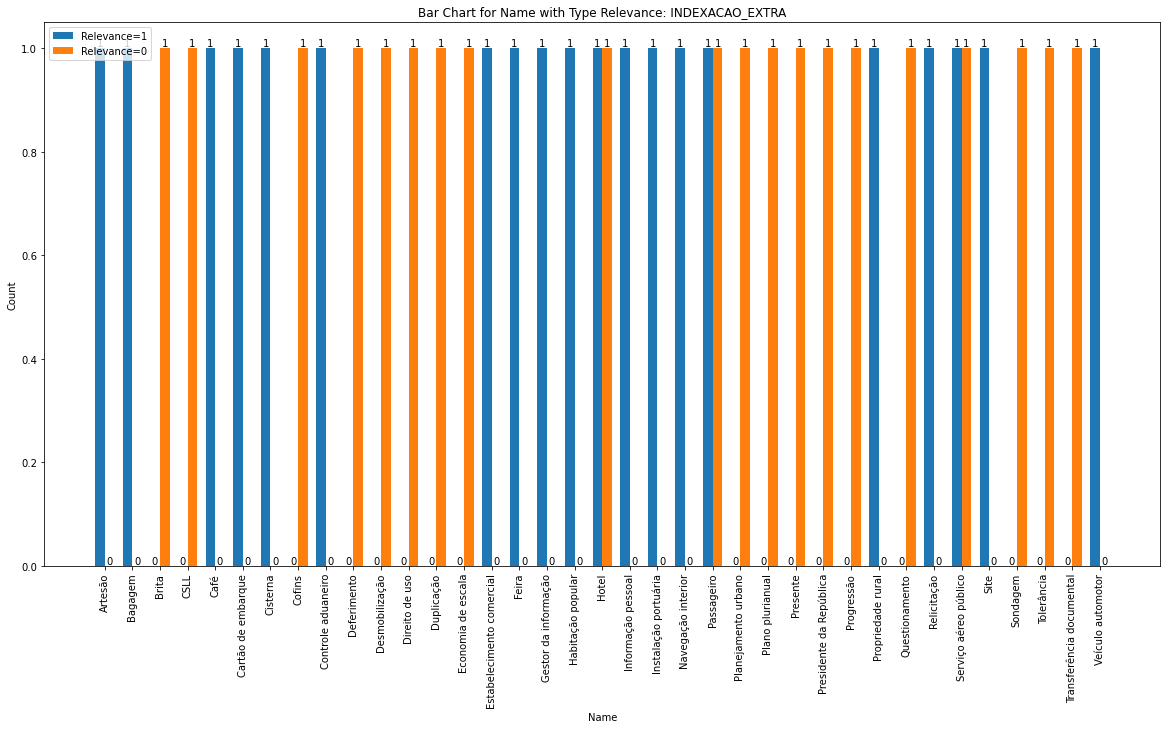

In [48]:

# Iterate over each property value in list_property
for property in list_property:
    if property == 'AREA':
        top_k = 10
    else:
        top_k = 20

    # Filter the DataFrame for the given property value in TYPE_RELEVANCE and relevance==1
    filtered_df_balanced_relevant = df_balanced[(df_balanced['TYPE_RELEVANCE'] == property) & (df_balanced['RELEVANCE'] == 1)]
    
    # Filter the DataFrame for the given property value in TYPE_RELEVANCE and relevance==0
    filtered_df_balanced_irrelevant = df_balanced[(df_balanced['TYPE_RELEVANCE'] == property) & (df_balanced['RELEVANCE'] == 0)]
    
    # Get the top_k names with the highest counts in the relevant dataframe
    top_relevant_names = filtered_df_balanced_relevant['NAME'].value_counts().tail(top_k)
    
    # Get the top_k names with the highest counts in the irrelevant dataframe
    top_irrelevant_names = filtered_df_balanced_irrelevant['NAME'].value_counts().tail(top_k)
    
    # Combine the unique names from both dataframes
    unique_names = np.union1d(top_relevant_names.index, top_irrelevant_names.index)
    
    # Calculate the count of each name in the relevant and irrelevant dataframes
    relevant_counts = top_relevant_names.reindex(unique_names, fill_value=0)
    irrelevant_counts = top_irrelevant_names.reindex(unique_names, fill_value=0)
    
    # Set the width for each bar
    bar_width = 0.35
    
    # Create the x-axis positions for the bars
    x = np.arange(len(unique_names))
    
    # Create the bar chart
    plt.figure(figsize=(20, 10))
    bars_relevant = plt.bar(x, relevant_counts, width=bar_width, label='Relevance=1')
    bars_irrelevant = plt.bar(x + bar_width, irrelevant_counts, width=bar_width, label='Relevance=0')
    
    # Set the labels and title
    plt.xlabel('Name')
    plt.ylabel('Count')
    plt.title(f'Bar Chart for Name with Type Relevance: {property}')
    
    # Set the x-axis ticks to the names
    plt.xticks(x + bar_width / 2, unique_names, rotation=90)
    
    # Print the number on top of each bar for relevance=1
    for bar in bars_relevant:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
    
    # Print the number on top of each bar for relevance=0
    for bar in bars_irrelevant:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
    
    # Add a legend
    plt.legend()
    
    # Display the chart
    plt.show()


In [ ]:
df.to_csv(PATH_TRAIN_DATA_GENERATED_V2, index=False)